In [354]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import requests
import geopandas as gpd
from shapely.geometry import LineString
import numpy as np
import geodatasets
import sqlite3
import plotly.express as px
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [355]:
#load dataset
victims_coords = pd.read_csv('victims_coords.csv')

victims_coords

,missing_persons_id,victim_name,age,park,state_name,year,latitude,longitude
0,1,David Michael Burney,46,Bankhead National Forest,Alabama,2007,34.301863,-87.414071
1,2,James Taylor Wall,30,Bankhead National Forest,Alabama,2015,34.301863,-87.414071
2,3,Kevin Robert O’Keefe,36,Glacier Bay National Park,Alaska,1985,58.814175,-136.872094
3,4,Micheal LeMaitre,65,Mt. Marathon,Alaska,2012,61.280047,-147.224095
4,5,Sandra Gelber,61,Glacier Bay National Park,Alaska,2014,58.814175,-136.872094
...,...,...,...,...,...,...,...,...
256,257,Frederick Gabriel,56,Canyonlands National Park,Utha,2015,38.233259,-109.920663
257,258,Carroll Donald Parkins,78,Mt. Hood National Forest,Oregon,2023,45.209965,-121.723232
258,259,Caleb Josiah Howard,32,Mt. Hood National Forest,Oregon,2017,45.209965,-121.723232
259,260,Cassie Renee Sheetz,24,Monongahela National Forest,West Virginia,2021,38.331613,-80.310683


In [356]:
#looking at overall info in dataset
victims_coords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   missing_persons_id  261 non-null    int64  
 1   victim_name         261 non-null    object 
 2   age                 261 non-null    object 
 3   park                261 non-null    object 
 4   state_name          261 non-null    object 
 5   year                261 non-null    int64  
 6   latitude            261 non-null    float64
 7   longitude           261 non-null    float64
dtypes: float64(2), int64(2), object(4)
memory usage: 16.4+ KB


In [357]:
#checking data types
print("Original Data Types:")
print(victims_coords.dtypes)

Original Data Types:
missing_persons_id      int64
victim_name            object
age                    object
park                   object
state_name             object
year                    int64
latitude              float64
longitude             float64
dtype: object


In [358]:
victims_coords.describe()

,missing_persons_id,year,latitude,longitude
count,261.00000,261.000000,261.000000,261.000000
mean,131.00000,1996.218391,39.507685,-111.763129
std,75.48841,23.133272,7.833014,16.377257
min,1.00000,1909.000000,-32.033425,-155.729700
25%,66.00000,1983.000000,36.251092,-121.171141
50%,131.00000,2002.000000,37.839300,-118.251816
75%,196.00000,2015.000000,44.038244,-109.315598
max,261.00000,2024.000000,61.280047,-52.099130


In [359]:
#looking at layout
victims_coords.head(10)

,missing_persons_id,victim_name,age,park,state_name,year,latitude,longitude
0,1,David Michael Burney,46,Bankhead National Forest,Alabama,2007,34.301863,-87.414071
1,2,James Taylor Wall,30,Bankhead National Forest,Alabama,2015,34.301863,-87.414071
2,3,Kevin Robert O’Keefe,36,Glacier Bay National Park,Alaska,1985,58.814175,-136.872094
3,4,Micheal LeMaitre,65,Mt. Marathon,Alaska,2012,61.280047,-147.224095
4,5,Sandra Gelber,61,Glacier Bay National Park,Alaska,2014,58.814175,-136.872094
5,6,Sharon Buis,48,Glacier Bay National Park,Alaska,2014,58.814175,-136.872094
6,7,Jonghyon Won,45,Grand Canyon,Arizona,2017,36.097743,-112.096762
7,8,Floyed E. Roberts III,52,Grand Canyon,Arizona,2016,36.097743,-112.096762
8,9,Morgan Heimer,22,Grand Canyon,Arizona,2015,36.097743,-112.096762
9,10,Drake Kramer,21,Grand Canyon,Arizona,2015,36.097743,-112.096762


In [360]:
#check for duplicates
victims_coords.duplicated().sum()

#print(victims_coords.duplicated().sum())

#remove duplicates
victims_coords = victims_coords.drop_duplicates()

#found 2 duplicate rows
victims_coords

,missing_persons_id,victim_name,age,park,state_name,year,latitude,longitude
0,1,David Michael Burney,46,Bankhead National Forest,Alabama,2007,34.301863,-87.414071
1,2,James Taylor Wall,30,Bankhead National Forest,Alabama,2015,34.301863,-87.414071
2,3,Kevin Robert O’Keefe,36,Glacier Bay National Park,Alaska,1985,58.814175,-136.872094
3,4,Micheal LeMaitre,65,Mt. Marathon,Alaska,2012,61.280047,-147.224095
4,5,Sandra Gelber,61,Glacier Bay National Park,Alaska,2014,58.814175,-136.872094
...,...,...,...,...,...,...,...,...
256,257,Frederick Gabriel,56,Canyonlands National Park,Utha,2015,38.233259,-109.920663
257,258,Carroll Donald Parkins,78,Mt. Hood National Forest,Oregon,2023,45.209965,-121.723232
258,259,Caleb Josiah Howard,32,Mt. Hood National Forest,Oregon,2017,45.209965,-121.723232
259,260,Cassie Renee Sheetz,24,Monongahela National Forest,West Virginia,2021,38.331613,-80.310683


In [361]:
#find missing values
missing_values = victims_coords.isnull()
missing_values

#Count missing values in each column
print(victims_coords.isna().sum())


missing_persons_id    0
victim_name           0
age                   0
park                  0
state_name            0
year                  0
latitude              0
longitude             0
dtype: int64


In [362]:
#manually found all the missing lat and long values and added them into dataset
#used google maps to find coordinates based on location information
missing_values

missing_values.isnull()

missing_values.any(axis=1)
missing_values[missing_values.any(axis=1)]  


,missing_persons_id,victim_name,age,park,state_name,year,latitude,longitude


In [363]:
# rename 'state' column to 'state_name' and 'name' to 'victim_name'
victims_coords = victims_coords.rename(columns={'state': 'state_name', 'name': 'victim_name'})


In [364]:
victims_coords

,missing_persons_id,victim_name,age,park,state_name,year,latitude,longitude
0,1,David Michael Burney,46,Bankhead National Forest,Alabama,2007,34.301863,-87.414071
1,2,James Taylor Wall,30,Bankhead National Forest,Alabama,2015,34.301863,-87.414071
2,3,Kevin Robert O’Keefe,36,Glacier Bay National Park,Alaska,1985,58.814175,-136.872094
3,4,Micheal LeMaitre,65,Mt. Marathon,Alaska,2012,61.280047,-147.224095
4,5,Sandra Gelber,61,Glacier Bay National Park,Alaska,2014,58.814175,-136.872094
...,...,...,...,...,...,...,...,...
256,257,Frederick Gabriel,56,Canyonlands National Park,Utha,2015,38.233259,-109.920663
257,258,Carroll Donald Parkins,78,Mt. Hood National Forest,Oregon,2023,45.209965,-121.723232
258,259,Caleb Josiah Howard,32,Mt. Hood National Forest,Oregon,2017,45.209965,-121.723232
259,260,Cassie Renee Sheetz,24,Monongahela National Forest,West Virginia,2021,38.331613,-80.310683


In [365]:
#converted the age unspecified and blank values to NaN
victims_coords.replace({'age': {'age unspecified': np.nan, '': np.nan}}, inplace=True)
print(victims_coords)




     missing_persons_id              victim_name  age  \
0                     1     David Michael Burney   46   
1                     2        James Taylor Wall   30   
2                     3     Kevin Robert O’Keefe   36   
3                     4         Micheal LeMaitre   65   
4                     5            Sandra Gelber   61   
..                  ...                      ...  ...   
256                 257        Frederick Gabriel   56   
257                 258   Carroll Donald Parkins   78   
258                 259      Caleb Josiah Howard   32   
259                 260      Cassie Renee Sheetz   24   
260                 261  Raymond Aronld Saunders   44   

                               park      state_name  year   latitude  \
0          Bankhead National Forest         Alabama  2007  34.301863   
1          Bankhead National Forest         Alabama  2015  34.301863   
2         Glacier Bay National Park          Alaska  1985  58.814175   
3                      Mt. 

In [366]:
victims_coords

,missing_persons_id,victim_name,age,park,state_name,year,latitude,longitude
0,1,David Michael Burney,46,Bankhead National Forest,Alabama,2007,34.301863,-87.414071
1,2,James Taylor Wall,30,Bankhead National Forest,Alabama,2015,34.301863,-87.414071
2,3,Kevin Robert O’Keefe,36,Glacier Bay National Park,Alaska,1985,58.814175,-136.872094
3,4,Micheal LeMaitre,65,Mt. Marathon,Alaska,2012,61.280047,-147.224095
4,5,Sandra Gelber,61,Glacier Bay National Park,Alaska,2014,58.814175,-136.872094
...,...,...,...,...,...,...,...,...
256,257,Frederick Gabriel,56,Canyonlands National Park,Utha,2015,38.233259,-109.920663
257,258,Carroll Donald Parkins,78,Mt. Hood National Forest,Oregon,2023,45.209965,-121.723232
258,259,Caleb Josiah Howard,32,Mt. Hood National Forest,Oregon,2017,45.209965,-121.723232
259,260,Cassie Renee Sheetz,24,Monongahela National Forest,West Virginia,2021,38.331613,-80.310683


In [367]:
victims_coords = victims_coords.rename(columns={'park': 'park_name'})

victims_coords

,missing_persons_id,victim_name,age,park_name,state_name,year,latitude,longitude
0,1,David Michael Burney,46,Bankhead National Forest,Alabama,2007,34.301863,-87.414071
1,2,James Taylor Wall,30,Bankhead National Forest,Alabama,2015,34.301863,-87.414071
2,3,Kevin Robert O’Keefe,36,Glacier Bay National Park,Alaska,1985,58.814175,-136.872094
3,4,Micheal LeMaitre,65,Mt. Marathon,Alaska,2012,61.280047,-147.224095
4,5,Sandra Gelber,61,Glacier Bay National Park,Alaska,2014,58.814175,-136.872094
...,...,...,...,...,...,...,...,...
256,257,Frederick Gabriel,56,Canyonlands National Park,Utha,2015,38.233259,-109.920663
257,258,Carroll Donald Parkins,78,Mt. Hood National Forest,Oregon,2023,45.209965,-121.723232
258,259,Caleb Josiah Howard,32,Mt. Hood National Forest,Oregon,2017,45.209965,-121.723232
259,260,Cassie Renee Sheetz,24,Monongahela National Forest,West Virginia,2021,38.331613,-80.310683


In [368]:
#set display option to see all rows so that I can find all missing values in dataset
pd.set_option('display.max_rows', None)

#set back to default rows after finding missing values
pd.set_option('display.max_rows', 10)   


In [369]:
#count occurrences
location_counts = victims_coords['park_name'].value_counts()

#count most frequent location
most_frequent_location = location_counts.idxmax()

#get the most frequent location
print('Most Frequent Location:', most_frequent_location)

Most Frequent Location: Yosemite National Park


In [370]:
# Convert 'age' column to numeric, coercing errors to NaN
victims_coords['age'] = pd.to_numeric(victims_coords['age'], errors='coerce')

# youngest victim
youngest_age = victims_coords['age'].min()
print("The youngest age is:", youngest_age)

# oldest victim
oldest_age = victims_coords['age'].max()
print("The oldest age is:", oldest_age)

#average age of victims
average_age = victims_coords['age'].mean()
print("The average age is:", average_age)

The youngest age is: 2.0
The oldest age is: 90.0
The average age is: 37.90416666666667


In [371]:
#check total number of victims for each location
victims_coords['park_name'].value_counts()

park_name
Yosemite National Park                 39
Grand Canyon                            8
Great Smoky Mountains National Park     7
Plumas National Forest                  5
Yellowstone National Park               5
                                       ..
 Canyonlands National Park              1
 Mt. Hood National Forest               1
  Mt. Hood National Forest              1
 Monongahela National Forest            1
 Smoky Mountains National Park          1
Name: count, Length: 147, dtype: int64

In [372]:
# GPS coordinates that the Appalachian Mountains cover
lat_min, lat_max = 34.000000, 47.000000
lon_min, lon_max = -80.000000, -70.000000  # -80 is west, -70 is east

# Find total amount of missing people inside the boundaries of the Appalachian Mountains using GPS coordinates
appalachian_mtn_victims = victims_coords[
	victims_coords['latitude'].between(lat_min, lat_max) &
	victims_coords['longitude'].between(lon_min, lon_max)
]

	# Return the count of victims in the Appalachian Mountains
appalachian_mtn_victims.shape[0] # total number of victims in the Appalachian Mountains

11

In [373]:
#check top 10 years with most victims
victims_coords['year'].value_counts().head(10)


year
2015    16
2017    11
2006    11
2010    10
2019     9
1996     8
2016     8
1998     8
1978     7
2021     7
Name: count, dtype: int64

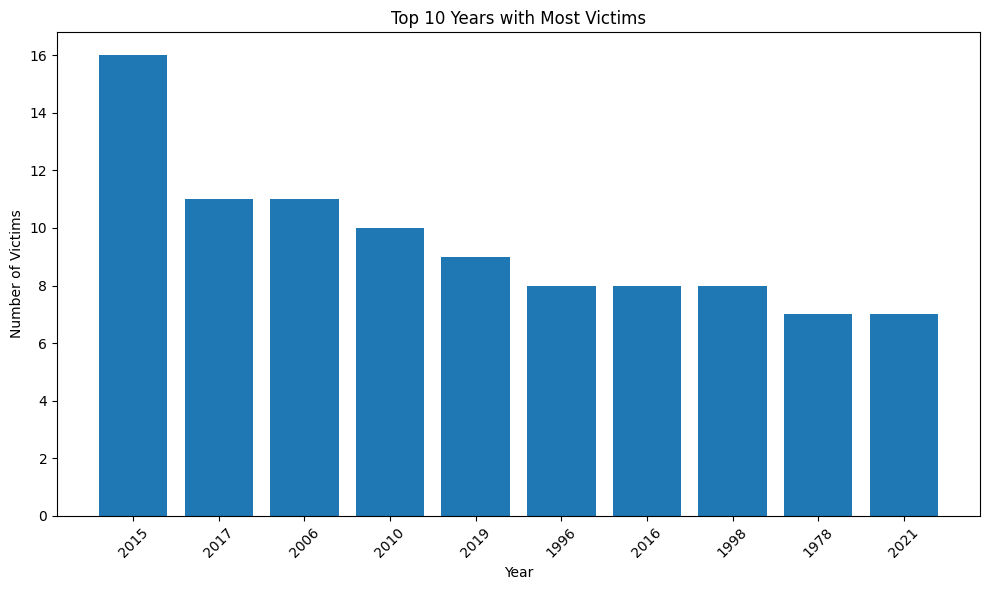

In [374]:
#visualize top 10 years with most victims
plt.figure(figsize=(10,6))
top_years = victims_coords['year'].value_counts().head(10)
plt.bar(top_years.index.astype(str), top_years.values)
plt.xlabel('Year')
plt.ylabel('Number of Victims')
plt.title('Top 10 Years with Most Victims')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [375]:
# Chose a bar plot to visualize the top 10 years with most victims because it effectively displays categorical data, allowing for easy comparison of the number of victims across different years.
# I used blue for the bars because it is a neutral color and stands out well against the white background.
# The labels and titles are clear and descriptive, making it easy to understand the information being presented.


In [376]:
# I chose a scatter plot to visualize the distribution of victims' coordinates because it effectively displays the geographical spread of incidents. Each point represents a victim's location, allowing us to identify clusters or patterns in specific areas. The scatter plot provides a clear visual representation of how victims are distributed across different longitudes and latitudes, making it easier to analyze spatial relationships and trends in the data...
# This type of plot is useful for identifying areas with higher concentrations of victims



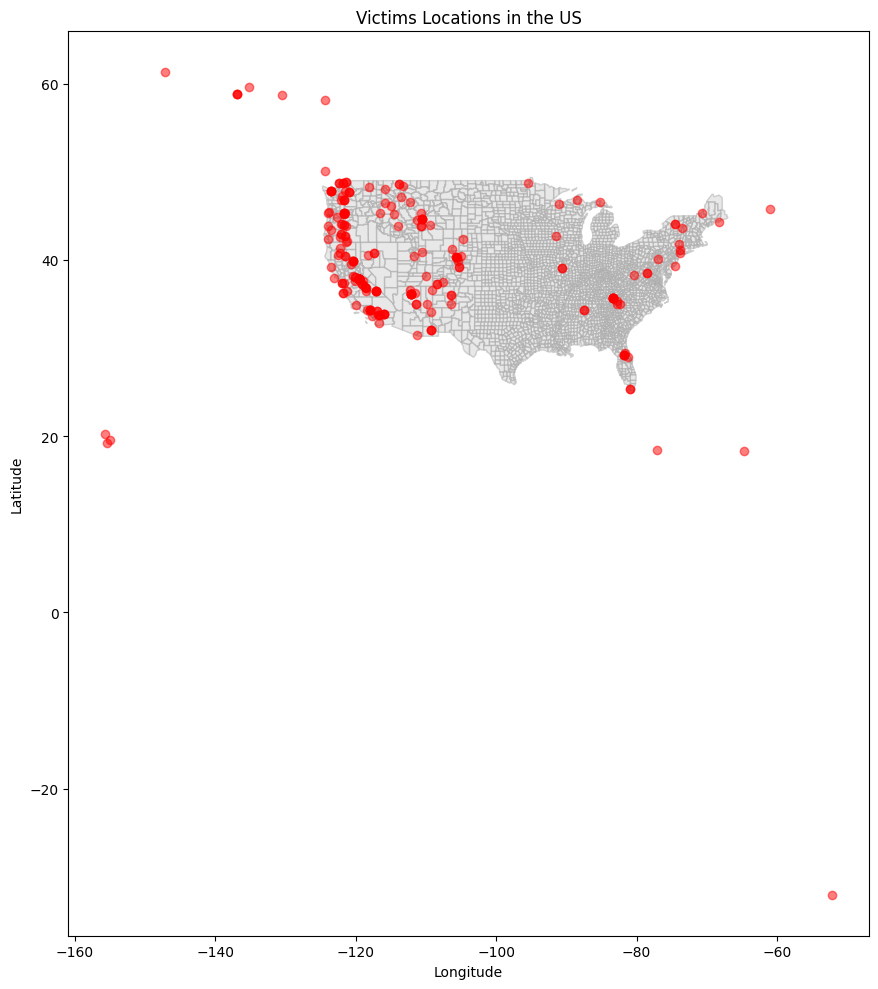

In [377]:
# create a scatter plot with a US map background using geopandas
# Load a base map of the US using geodatasets
us_states_fp = geodatasets.get_path("geoda.natregimes")
usa = gpd.read_file(us_states_fp)

#plotting the map
fig, ax = plt.subplots(figsize=(15,10))
usa.plot(ax=ax, color='lightgrey', edgecolor='darkgrey', alpha=0.5)
ax.scatter(victims_coords['longitude'], victims_coords['latitude'], color='red', alpha=0.5)
ax.set_title('Victims Locations in the US')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

In [378]:
# I installed and used the geopandas library to create a scatter plot with a US map background.
# Like the previous scatter plot, this visualization effectively displays the geographical distribution of victims across the United States. By overlaying the victims' coordinates on a map of the US, it provides a clearer context for understanding where incidents are concentrated in relation to state boundaries and geographical features. This type of plot is particularly useful for identifying regional patterns and hotspots, making it easier to analyze spatial relationships and trends in the data on a national scale.
# By using the map background, you can start to see where the clusters of victims are located in relation to the states and regions of the US.
# You can now see there is a cluster of victims in the Appalachian Mountain region as well as some in the western US, near Grand Teton National Park in Wyoming.
# I chose red so that the points stand out against the light gray background. Also, because red is often associated with urgency and danger.

In [379]:
#load new dataset
bfro_locations = pd.read_csv('bfro_locations.csv')

bfro_locations

,number,title,classification,timestamp,latitude,longitude
0,637,Report 637: Campers' encounter just after dark...,Class A,2000-06-16T12:00:00Z,61.50000,-142.90000
1,2917,Report 2917: Family observes large biped from car,Class A,1995-05-15T12:00:00Z,55.18720,-132.79820
2,7963,Report 7963: Sasquatch walks past window of ho...,Class A,2004-02-09T12:00:00Z,55.20350,-132.82020
3,9317,"Report 9317: Driver on Alcan Highway has noon,...",Class A,2004-06-18T12:00:00Z,62.93750,-141.56670
4,13038,Report 13038: Snowmobiler has encounter in dee...,Class A,2004-02-15T12:00:00Z,61.05950,-149.78530
...,...,...,...,...,...,...
4304,4159,Report 4159: Campers hear unusual grunting sou...,Class C,1995-11-15T12:00:00Z,31.22333,-94.96611
4305,175,Report 175: Campers encounter large animal nea...,Class C,2000-07-30T12:00:00Z,47.47745,-121.04150
4306,945,Report 945: Creature with red glowing eyes seen,Class C,1999-03-19T12:00:00Z,47.57778,-124.29330
4307,1387,Report 1387: Father and son hear heavy footste...,Class C,1983-08-17T12:00:00Z,47.51030,-122.04560


In [380]:
bfro_locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4309 entries, 0 to 4308
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   number          4309 non-null   int64  
 1   title           4309 non-null   object 
 2   classification  4309 non-null   object 
 3   timestamp       4309 non-null   object 
 4   latitude        4309 non-null   float64
 5   longitude       4309 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 202.1+ KB


In [381]:
bfro_locations.describe()

,number,latitude,longitude
count,4309.000000,4309.000000,4.309000e+03
mean,23270.103504,39.838115,-6.593093e+04
std,19781.610023,6.009804,2.015040e+06
min,60.000000,25.141000,-9.486840e+07
25%,7003.000000,35.626700,-1.180883e+02
50%,17570.000000,39.641930,-9.232704e+01
75%,35427.000000,44.825000,-8.311422e+01
max,75577.000000,64.891390,-6.383683e+01


In [382]:
#check for duplicates
bfro_locations.duplicated().sum()

#no duplicates found

np.int64(0)

In [383]:
#find missing values
missing_values = bfro_locations.isnull()
missing_values

#Count missing values in each column
print(bfro_locations.isna().sum())

number            0
title             0
classification    0
timestamp         0
latitude          0
longitude         0
dtype: int64


In [384]:
bfro_locations


,number,title,classification,timestamp,latitude,longitude
0,637,Report 637: Campers' encounter just after dark...,Class A,2000-06-16T12:00:00Z,61.50000,-142.90000
1,2917,Report 2917: Family observes large biped from car,Class A,1995-05-15T12:00:00Z,55.18720,-132.79820
2,7963,Report 7963: Sasquatch walks past window of ho...,Class A,2004-02-09T12:00:00Z,55.20350,-132.82020
3,9317,"Report 9317: Driver on Alcan Highway has noon,...",Class A,2004-06-18T12:00:00Z,62.93750,-141.56670
4,13038,Report 13038: Snowmobiler has encounter in dee...,Class A,2004-02-15T12:00:00Z,61.05950,-149.78530
...,...,...,...,...,...,...
4304,4159,Report 4159: Campers hear unusual grunting sou...,Class C,1995-11-15T12:00:00Z,31.22333,-94.96611
4305,175,Report 175: Campers encounter large animal nea...,Class C,2000-07-30T12:00:00Z,47.47745,-121.04150
4306,945,Report 945: Creature with red glowing eyes seen,Class C,1999-03-19T12:00:00Z,47.57778,-124.29330
4307,1387,Report 1387: Father and son hear heavy footste...,Class C,1983-08-17T12:00:00Z,47.51030,-122.04560


In [385]:
# find city in 'title' column and create new 'city' column
bfro_locations['city'] = bfro_locations['title'].str.extract(r'(\d{1,2}/\d{1,2}/\d{4})')
bfro_locations

# delete 'city' column                      
bfro_locations = bfro_locations.drop(columns=['city']) 

bfro_locations

,number,title,classification,timestamp,latitude,longitude
0,637,Report 637: Campers' encounter just after dark...,Class A,2000-06-16T12:00:00Z,61.50000,-142.90000
1,2917,Report 2917: Family observes large biped from car,Class A,1995-05-15T12:00:00Z,55.18720,-132.79820
2,7963,Report 7963: Sasquatch walks past window of ho...,Class A,2004-02-09T12:00:00Z,55.20350,-132.82020
3,9317,"Report 9317: Driver on Alcan Highway has noon,...",Class A,2004-06-18T12:00:00Z,62.93750,-141.56670
4,13038,Report 13038: Snowmobiler has encounter in dee...,Class A,2004-02-15T12:00:00Z,61.05950,-149.78530
...,...,...,...,...,...,...
4304,4159,Report 4159: Campers hear unusual grunting sou...,Class C,1995-11-15T12:00:00Z,31.22333,-94.96611
4305,175,Report 175: Campers encounter large animal nea...,Class C,2000-07-30T12:00:00Z,47.47745,-121.04150
4306,945,Report 945: Creature with red glowing eyes seen,Class C,1999-03-19T12:00:00Z,47.57778,-124.29330
4307,1387,Report 1387: Father and son hear heavy footste...,Class C,1983-08-17T12:00:00Z,47.51030,-122.04560


In [386]:
bfro_locations = bfro_locations.rename(columns={'number': 'bigfoot_sighting_id', 'title': 'description'})

bfro_locations

,bigfoot_sighting_id,description,classification,timestamp,latitude,longitude
0,637,Report 637: Campers' encounter just after dark...,Class A,2000-06-16T12:00:00Z,61.50000,-142.90000
1,2917,Report 2917: Family observes large biped from car,Class A,1995-05-15T12:00:00Z,55.18720,-132.79820
2,7963,Report 7963: Sasquatch walks past window of ho...,Class A,2004-02-09T12:00:00Z,55.20350,-132.82020
3,9317,"Report 9317: Driver on Alcan Highway has noon,...",Class A,2004-06-18T12:00:00Z,62.93750,-141.56670
4,13038,Report 13038: Snowmobiler has encounter in dee...,Class A,2004-02-15T12:00:00Z,61.05950,-149.78530
...,...,...,...,...,...,...
4304,4159,Report 4159: Campers hear unusual grunting sou...,Class C,1995-11-15T12:00:00Z,31.22333,-94.96611
4305,175,Report 175: Campers encounter large animal nea...,Class C,2000-07-30T12:00:00Z,47.47745,-121.04150
4306,945,Report 945: Creature with red glowing eyes seen,Class C,1999-03-19T12:00:00Z,47.57778,-124.29330
4307,1387,Report 1387: Father and son hear heavy footste...,Class C,1983-08-17T12:00:00Z,47.51030,-122.04560


In [387]:
updated_us_cave_systems = pd.read_csv('updated_us_cave_systems.csv')

updated_us_cave_systems



,#,System,Length,Location,Coordinates,"Associated parks,\nprotected areas",Access,latitude,longitude
0,1,Mammoth Cave,685.6 km (426.0 mi)[2][3][1],"Brownsville, Kentucky",37°11′15″N86°06′13″W﻿ / ﻿37.18758°N 86.10357°W...,"Mammoth Cave National Park, also a World Herit...",Some public access[4],NaN,NaN
1,2,Jewel Cave,354.86 km (220.5 mi)[5][6][1],"Custer, South Dakota",43°43′46″N103°49′46″W﻿ / ﻿43.72944°N 103.82944...,Jewel Cave National Monument,Some public access[7],NaN,NaN
2,3,Wind Cave,270.498 km (168.1 mi)[8][1],"Hot Springs, South Dakota",43°33′29″N103°28′46″W﻿ / ﻿43.55804°N 103.47955...,Wind Cave National Park,Some public access,NaN,NaN
3,4,Lechuguilla Cave,244.8 km (152.1 mi)[9][10][1],"Carlsbad, New Mexico",32°11′26″N104°30′12″W﻿ / ﻿32.1906420°N 104.503...,Carlsbad Caverns National Park,"Restricted access, requires authorization[11]",NaN,NaN
4,5,Fisher Ridge Cave System,215.908 km (134.2 mi)[1],"Brownsville, Kentucky",37°11′14″N85°58′30″W﻿ / ﻿37.1873°N 85.9751°W﻿ ...,partly within Mammoth Cave National Park,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
14,15,Carlsbad Caverns,63.5 km (39.46 mi)[19],"Carlsbad, New Mexico",32°10′37″N104°26′28″W﻿ / ﻿32.177057°N 104.4410...,Carlsbad Caverns National Park,Public access.[24],NaN,NaN
15,16,Organ Cave,61.9 km (38.46 mi)[19],"Greenbrier County, West Virginia",37°43′05″N80°26′11″W﻿ / ﻿37.7181564°N 80.43629...,None. Entrances on private property.,Some entrances closed. Some entrances require ...,NaN,NaN
16,17,Wakulla-Leon Sinks Cave System,56.6 km (35.17 mi)[25],"Wakulla County, Florida",30°14′07″N84°18′10″W﻿ / ﻿30.2354147°N 84.30287...,None. Underwater cave system.,NaN,NaN,NaN
17,18,Whigpistle System,55.7 km (34.61 mi)[26][27],"Edmonson County, Kentucky",37°07′11″N86°08′10″W﻿ / ﻿37.1196°N 86.1362°W﻿ ...,none,NaN,NaN,NaN


In [388]:
# fill in missing coordinates with known coordinates for Carlsbad Caverns National Park
updated_us_cave_systems['Coordinates'] = updated_us_cave_systems['Coordinates'].fillna('35.16.33.6.N111.35.35.0W / 35.16.32.3N111.35.31.2W')

In [389]:
updated_us_cave_systems = pd.read_csv('updated_us_cave_systems.csv')

updated_us_cave_systems

,#,System,Length,Location,Coordinates,"Associated parks,\nprotected areas",Access,latitude,longitude
0,1,Mammoth Cave,685.6 km (426.0 mi)[2][3][1],"Brownsville, Kentucky",37°11′15″N86°06′13″W﻿ / ﻿37.18758°N 86.10357°W...,"Mammoth Cave National Park, also a World Herit...",Some public access[4],NaN,NaN
1,2,Jewel Cave,354.86 km (220.5 mi)[5][6][1],"Custer, South Dakota",43°43′46″N103°49′46″W﻿ / ﻿43.72944°N 103.82944...,Jewel Cave National Monument,Some public access[7],NaN,NaN
2,3,Wind Cave,270.498 km (168.1 mi)[8][1],"Hot Springs, South Dakota",43°33′29″N103°28′46″W﻿ / ﻿43.55804°N 103.47955...,Wind Cave National Park,Some public access,NaN,NaN
3,4,Lechuguilla Cave,244.8 km (152.1 mi)[9][10][1],"Carlsbad, New Mexico",32°11′26″N104°30′12″W﻿ / ﻿32.1906420°N 104.503...,Carlsbad Caverns National Park,"Restricted access, requires authorization[11]",NaN,NaN
4,5,Fisher Ridge Cave System,215.908 km (134.2 mi)[1],"Brownsville, Kentucky",37°11′14″N85°58′30″W﻿ / ﻿37.1873°N 85.9751°W﻿ ...,partly within Mammoth Cave National Park,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
14,15,Carlsbad Caverns,63.5 km (39.46 mi)[19],"Carlsbad, New Mexico",32°10′37″N104°26′28″W﻿ / ﻿32.177057°N 104.4410...,Carlsbad Caverns National Park,Public access.[24],NaN,NaN
15,16,Organ Cave,61.9 km (38.46 mi)[19],"Greenbrier County, West Virginia",37°43′05″N80°26′11″W﻿ / ﻿37.7181564°N 80.43629...,None. Entrances on private property.,Some entrances closed. Some entrances require ...,NaN,NaN
16,17,Wakulla-Leon Sinks Cave System,56.6 km (35.17 mi)[25],"Wakulla County, Florida",30°14′07″N84°18′10″W﻿ / ﻿30.2354147°N 84.30287...,None. Underwater cave system.,NaN,NaN,NaN
17,18,Whigpistle System,55.7 km (34.61 mi)[26][27],"Edmonson County, Kentucky",37°07′11″N86°08′10″W﻿ / ﻿37.1196°N 86.1362°W﻿ ...,none,NaN,NaN,NaN


In [390]:
updated_us_cave_systems

,#,System,Length,Location,Coordinates,"Associated parks,\nprotected areas",Access,latitude,longitude
0,1,Mammoth Cave,685.6 km (426.0 mi)[2][3][1],"Brownsville, Kentucky",37°11′15″N86°06′13″W﻿ / ﻿37.18758°N 86.10357°W...,"Mammoth Cave National Park, also a World Herit...",Some public access[4],NaN,NaN
1,2,Jewel Cave,354.86 km (220.5 mi)[5][6][1],"Custer, South Dakota",43°43′46″N103°49′46″W﻿ / ﻿43.72944°N 103.82944...,Jewel Cave National Monument,Some public access[7],NaN,NaN
2,3,Wind Cave,270.498 km (168.1 mi)[8][1],"Hot Springs, South Dakota",43°33′29″N103°28′46″W﻿ / ﻿43.55804°N 103.47955...,Wind Cave National Park,Some public access,NaN,NaN
3,4,Lechuguilla Cave,244.8 km (152.1 mi)[9][10][1],"Carlsbad, New Mexico",32°11′26″N104°30′12″W﻿ / ﻿32.1906420°N 104.503...,Carlsbad Caverns National Park,"Restricted access, requires authorization[11]",NaN,NaN
4,5,Fisher Ridge Cave System,215.908 km (134.2 mi)[1],"Brownsville, Kentucky",37°11′14″N85°58′30″W﻿ / ﻿37.1873°N 85.9751°W﻿ ...,partly within Mammoth Cave National Park,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
14,15,Carlsbad Caverns,63.5 km (39.46 mi)[19],"Carlsbad, New Mexico",32°10′37″N104°26′28″W﻿ / ﻿32.177057°N 104.4410...,Carlsbad Caverns National Park,Public access.[24],NaN,NaN
15,16,Organ Cave,61.9 km (38.46 mi)[19],"Greenbrier County, West Virginia",37°43′05″N80°26′11″W﻿ / ﻿37.7181564°N 80.43629...,None. Entrances on private property.,Some entrances closed. Some entrances require ...,NaN,NaN
16,17,Wakulla-Leon Sinks Cave System,56.6 km (35.17 mi)[25],"Wakulla County, Florida",30°14′07″N84°18′10″W﻿ / ﻿30.2354147°N 84.30287...,None. Underwater cave system.,NaN,NaN,NaN
17,18,Whigpistle System,55.7 km (34.61 mi)[26][27],"Edmonson County, Kentucky",37°07′11″N86°08′10″W﻿ / ﻿37.1196°N 86.1362°W﻿ ...,none,NaN,NaN,NaN


In [391]:
# Create new column by splitting the 'coordinates' column and extracting value after ; into 'longitude' column
updated_us_cave_systems['longitude'] = updated_us_cave_systems['Coordinates'].str.split('; ').str[1]

# create new column by splitting the 'coordinates' column and extracting value after // and before ; into 'latitude' column
updated_us_cave_systems['latitude'] = updated_us_cave_systems['Coordinates'].str.split('; ').str[0]

# delete all value before // in latitude column
updated_us_cave_systems['latitude'] = updated_us_cave_systems['latitude'].str.split('//').str[1]

#why is latitude column outputting NaN values?
updated_us_cave_systems


updated_us_cave_systems




,#,System,Length,Location,Coordinates,"Associated parks,\nprotected areas",Access,latitude,longitude
0,1,Mammoth Cave,685.6 km (426.0 mi)[2][3][1],"Brownsville, Kentucky",37°11′15″N86°06′13″W﻿ / ﻿37.18758°N 86.10357°W...,"Mammoth Cave National Park, also a World Herit...",Some public access[4],NaN,-86.10357﻿ (Mammoth \ncave historic entrance)
1,2,Jewel Cave,354.86 km (220.5 mi)[5][6][1],"Custer, South Dakota",43°43′46″N103°49′46″W﻿ / ﻿43.72944°N 103.82944...,Jewel Cave National Monument,Some public access[7],NaN,-103.82944﻿ (Jewel \nCave)
2,3,Wind Cave,270.498 km (168.1 mi)[8][1],"Hot Springs, South Dakota",43°33′29″N103°28′46″W﻿ / ﻿43.55804°N 103.47955...,Wind Cave National Park,Some public access,NaN,-103.47955﻿ (Wind \nCave)
3,4,Lechuguilla Cave,244.8 km (152.1 mi)[9][10][1],"Carlsbad, New Mexico",32°11′26″N104°30′12″W﻿ / ﻿32.1906420°N 104.503...,Carlsbad Caverns National Park,"Restricted access, requires authorization[11]",NaN,\n-104.5033091﻿ (Grotte de Lechuguilla)
4,5,Fisher Ridge Cave System,215.908 km (134.2 mi)[1],"Brownsville, Kentucky",37°11′14″N85°58′30″W﻿ / ﻿37.1873°N 85.9751°W﻿ ...,partly within Mammoth Cave National Park,NaN,NaN,-85.9751﻿ (Fisher \nRidge System Historic Entr...
...,...,...,...,...,...,...,...,...,...
14,15,Carlsbad Caverns,63.5 km (39.46 mi)[19],"Carlsbad, New Mexico",32°10′37″N104°26′28″W﻿ / ﻿32.177057°N 104.4410...,Carlsbad Caverns National Park,Public access.[24],NaN,-104.441039
15,16,Organ Cave,61.9 km (38.46 mi)[19],"Greenbrier County, West Virginia",37°43′05″N80°26′11″W﻿ / ﻿37.7181564°N 80.43629...,None. Entrances on private property.,Some entrances closed. Some entrances require ...,NaN,\n-80.4362982
16,17,Wakulla-Leon Sinks Cave System,56.6 km (35.17 mi)[25],"Wakulla County, Florida",30°14′07″N84°18′10″W﻿ / ﻿30.2354147°N 84.30287...,None. Underwater cave system.,NaN,NaN,\n-84.3028754
17,18,Whigpistle System,55.7 km (34.61 mi)[26][27],"Edmonson County, Kentucky",37°07′11″N86°08′10″W﻿ / ﻿37.1196°N 86.1362°W﻿ ...,none,NaN,NaN,-86.1362﻿ (Whigpistle \nSystem Whigpistle Entr...


In [392]:
import re

def dms_to_dd(d, m, s, hem):
    dd = float(d) + float(m) / 60 + float(s) / 3600
    if hem.upper() in ('S', 'W'):
        dd = -dd
    return dd

# regexes to match decimal degrees with direction, plain signed decimals, and DMS
dec_with_dir = re.compile(r'([0-9]{1,3}\.\d+)[°\s]*([NnSs]).*?([0-9]{1,3}\.\d+)[°\s]*([EeWw])')
signed_dec = re.compile(r'-?\d+\.\d+')
dms_pair = re.compile(r'(\d{1,3})[°\s]+(\d{1,2})[\'′\s]+(\d{1,2}(?:\.\d+)?)[\"″\s]*([NnSsEeWw])')

def parse_coordinates(s):
    if pd.isna(s):
        return pd.Series([np.nan, np.nan])

    # 1) decimal degrees with N/S and E/W (e.g. "37.18758°N 86.10357°W")
    m = dec_with_dir.search(s)
    if m:
        lat = float(m.group(1)) * (1 if m.group(2).upper() == 'N' else -1)
        lon = float(m.group(3)) * (1 if m.group(4).upper() == 'E' else -1)
        return pd.Series([lat, lon])

    # 2) any two signed decimals appearing in the string (heuristic)
    nums = signed_dec.findall(s)
    if len(nums) >= 2:
        a, b = map(float, nums[:2])
        # heuristic: latitude must be within [-90, 90]
        if abs(a) <= 90 and abs(b) <= 180:
            return pd.Series([a, b])
        if abs(b) <= 90 and abs(a) <= 180:
            return pd.Series([b, a])
        return pd.Series([np.nan, np.nan])

    # 3) try parsing two DMS occurrences (degree/min/sec + direction)
    dms_matches = dms_pair.findall(s)
    if len(dms_matches) >= 2:
        lat = dms_to_dd(dms_matches[0][0], dms_matches[0][1], dms_matches[0][2], dms_matches[0][3])
        lon = dms_to_dd(dms_matches[1][0], dms_matches[1][1], dms_matches[1][2], dms_matches[1][3])
        return pd.Series([lat, lon])

    return pd.Series([np.nan, np.nan])

# parse and write back into the dataframe
updated_us_cave_systems[['latitude_parsed', 'longitude_parsed']] = updated_us_cave_systems['Coordinates'].apply(parse_coordinates)

# fill the missing latitude (was all NaN) and clean/merge longitude
updated_us_cave_systems['latitude'] = updated_us_cave_systems['latitude_parsed']

# try to extract a clean numeric longitude from the existing 'longitude' column, otherwise use parsed
existing_lon_num = updated_us_cave_systems['longitude'].astype(str).str.extract(r'(-?\d+\.\d+)')[0].astype(float)
updated_us_cave_systems['longitude'] = existing_lon_num.fillna(updated_us_cave_systems['longitude_parsed'])

# drop helper columns
updated_us_cave_systems.drop(columns=['latitude_parsed', 'longitude_parsed'], inplace=True)

# show results
updated_us_cave_systems[['Coordinates', 'latitude', 'longitude']]


,Coordinates,latitude,longitude
0,37°11′15″N86°06′13″W﻿ / ﻿37.18758°N 86.10357°W...,37.187580,-86.103570
1,43°43′46″N103°49′46″W﻿ / ﻿43.72944°N 103.82944...,43.729440,-103.829440
2,43°33′29″N103°28′46″W﻿ / ﻿43.55804°N 103.47955...,43.558040,-103.479550
3,32°11′26″N104°30′12″W﻿ / ﻿32.1906420°N 104.503...,32.190642,-104.503309
4,37°11′14″N85°58′30″W﻿ / ﻿37.1873°N 85.9751°W﻿ ...,37.187300,-85.975100
...,...,...,...
14,32°10′37″N104°26′28″W﻿ / ﻿32.177057°N 104.4410...,32.177057,-104.441039
15,37°43′05″N80°26′11″W﻿ / ﻿37.7181564°N 80.43629...,37.718156,-80.436298
16,30°14′07″N84°18′10″W﻿ / ﻿30.2354147°N 84.30287...,30.235415,-84.302875
17,37°07′11″N86°08′10″W﻿ / ﻿37.1196°N 86.1362°W﻿ ...,37.119600,-86.136200


In [393]:
updated_us_cave_systems

,#,System,Length,Location,Coordinates,"Associated parks,\nprotected areas",Access,latitude,longitude
0,1,Mammoth Cave,685.6 km (426.0 mi)[2][3][1],"Brownsville, Kentucky",37°11′15″N86°06′13″W﻿ / ﻿37.18758°N 86.10357°W...,"Mammoth Cave National Park, also a World Herit...",Some public access[4],37.187580,-86.103570
1,2,Jewel Cave,354.86 km (220.5 mi)[5][6][1],"Custer, South Dakota",43°43′46″N103°49′46″W﻿ / ﻿43.72944°N 103.82944...,Jewel Cave National Monument,Some public access[7],43.729440,-103.829440
2,3,Wind Cave,270.498 km (168.1 mi)[8][1],"Hot Springs, South Dakota",43°33′29″N103°28′46″W﻿ / ﻿43.55804°N 103.47955...,Wind Cave National Park,Some public access,43.558040,-103.479550
3,4,Lechuguilla Cave,244.8 km (152.1 mi)[9][10][1],"Carlsbad, New Mexico",32°11′26″N104°30′12″W﻿ / ﻿32.1906420°N 104.503...,Carlsbad Caverns National Park,"Restricted access, requires authorization[11]",32.190642,-104.503309
4,5,Fisher Ridge Cave System,215.908 km (134.2 mi)[1],"Brownsville, Kentucky",37°11′14″N85°58′30″W﻿ / ﻿37.1873°N 85.9751°W﻿ ...,partly within Mammoth Cave National Park,NaN,37.187300,-85.975100
...,...,...,...,...,...,...,...,...,...
14,15,Carlsbad Caverns,63.5 km (39.46 mi)[19],"Carlsbad, New Mexico",32°10′37″N104°26′28″W﻿ / ﻿32.177057°N 104.4410...,Carlsbad Caverns National Park,Public access.[24],32.177057,-104.441039
15,16,Organ Cave,61.9 km (38.46 mi)[19],"Greenbrier County, West Virginia",37°43′05″N80°26′11″W﻿ / ﻿37.7181564°N 80.43629...,None. Entrances on private property.,Some entrances closed. Some entrances require ...,37.718156,-80.436298
16,17,Wakulla-Leon Sinks Cave System,56.6 km (35.17 mi)[25],"Wakulla County, Florida",30°14′07″N84°18′10″W﻿ / ﻿30.2354147°N 84.30287...,None. Underwater cave system.,NaN,30.235415,-84.302875
17,18,Whigpistle System,55.7 km (34.61 mi)[26][27],"Edmonson County, Kentucky",37°07′11″N86°08′10″W﻿ / ﻿37.1196°N 86.1362°W﻿ ...,none,NaN,37.119600,-86.136200


In [394]:
# separate 'Location' column into two separate columns, 'city' and 'state
updated_us_cave_systems['city'] = updated_us_cave_systems['Location'].str.split(', ').str[0]

updated_us_cave_systems

,#,System,Length,Location,Coordinates,"Associated parks,\nprotected areas",Access,latitude,longitude,city
0,1,Mammoth Cave,685.6 km (426.0 mi)[2][3][1],"Brownsville, Kentucky",37°11′15″N86°06′13″W﻿ / ﻿37.18758°N 86.10357°W...,"Mammoth Cave National Park, also a World Herit...",Some public access[4],37.187580,-86.103570,Brownsville
1,2,Jewel Cave,354.86 km (220.5 mi)[5][6][1],"Custer, South Dakota",43°43′46″N103°49′46″W﻿ / ﻿43.72944°N 103.82944...,Jewel Cave National Monument,Some public access[7],43.729440,-103.829440,Custer
2,3,Wind Cave,270.498 km (168.1 mi)[8][1],"Hot Springs, South Dakota",43°33′29″N103°28′46″W﻿ / ﻿43.55804°N 103.47955...,Wind Cave National Park,Some public access,43.558040,-103.479550,Hot Springs
3,4,Lechuguilla Cave,244.8 km (152.1 mi)[9][10][1],"Carlsbad, New Mexico",32°11′26″N104°30′12″W﻿ / ﻿32.1906420°N 104.503...,Carlsbad Caverns National Park,"Restricted access, requires authorization[11]",32.190642,-104.503309,Carlsbad
4,5,Fisher Ridge Cave System,215.908 km (134.2 mi)[1],"Brownsville, Kentucky",37°11′14″N85°58′30″W﻿ / ﻿37.1873°N 85.9751°W﻿ ...,partly within Mammoth Cave National Park,NaN,37.187300,-85.975100,Brownsville
...,...,...,...,...,...,...,...,...,...,...
14,15,Carlsbad Caverns,63.5 km (39.46 mi)[19],"Carlsbad, New Mexico",32°10′37″N104°26′28″W﻿ / ﻿32.177057°N 104.4410...,Carlsbad Caverns National Park,Public access.[24],32.177057,-104.441039,Carlsbad
15,16,Organ Cave,61.9 km (38.46 mi)[19],"Greenbrier County, West Virginia",37°43′05″N80°26′11″W﻿ / ﻿37.7181564°N 80.43629...,None. Entrances on private property.,Some entrances closed. Some entrances require ...,37.718156,-80.436298,Greenbrier County
16,17,Wakulla-Leon Sinks Cave System,56.6 km (35.17 mi)[25],"Wakulla County, Florida",30°14′07″N84°18′10″W﻿ / ﻿30.2354147°N 84.30287...,None. Underwater cave system.,NaN,30.235415,-84.302875,Wakulla County
17,18,Whigpistle System,55.7 km (34.61 mi)[26][27],"Edmonson County, Kentucky",37°07′11″N86°08′10″W﻿ / ﻿37.1196°N 86.1362°W﻿ ...,none,NaN,37.119600,-86.136200,Edmonson County


In [395]:
# separate 'Location' column into two separate columns, 'city' and 'state
updated_us_cave_systems['state'] = updated_us_cave_systems['Location'].str.split(', ').str[1]

updated_us_cave_systems

,#,System,Length,Location,Coordinates,"Associated parks,\nprotected areas",Access,latitude,longitude,city,state
0,1,Mammoth Cave,685.6 km (426.0 mi)[2][3][1],"Brownsville, Kentucky",37°11′15″N86°06′13″W﻿ / ﻿37.18758°N 86.10357°W...,"Mammoth Cave National Park, also a World Herit...",Some public access[4],37.187580,-86.103570,Brownsville,Kentucky
1,2,Jewel Cave,354.86 km (220.5 mi)[5][6][1],"Custer, South Dakota",43°43′46″N103°49′46″W﻿ / ﻿43.72944°N 103.82944...,Jewel Cave National Monument,Some public access[7],43.729440,-103.829440,Custer,South Dakota
2,3,Wind Cave,270.498 km (168.1 mi)[8][1],"Hot Springs, South Dakota",43°33′29″N103°28′46″W﻿ / ﻿43.55804°N 103.47955...,Wind Cave National Park,Some public access,43.558040,-103.479550,Hot Springs,South Dakota
3,4,Lechuguilla Cave,244.8 km (152.1 mi)[9][10][1],"Carlsbad, New Mexico",32°11′26″N104°30′12″W﻿ / ﻿32.1906420°N 104.503...,Carlsbad Caverns National Park,"Restricted access, requires authorization[11]",32.190642,-104.503309,Carlsbad,New Mexico
4,5,Fisher Ridge Cave System,215.908 km (134.2 mi)[1],"Brownsville, Kentucky",37°11′14″N85°58′30″W﻿ / ﻿37.1873°N 85.9751°W﻿ ...,partly within Mammoth Cave National Park,NaN,37.187300,-85.975100,Brownsville,Kentucky
...,...,...,...,...,...,...,...,...,...,...,...
14,15,Carlsbad Caverns,63.5 km (39.46 mi)[19],"Carlsbad, New Mexico",32°10′37″N104°26′28″W﻿ / ﻿32.177057°N 104.4410...,Carlsbad Caverns National Park,Public access.[24],32.177057,-104.441039,Carlsbad,New Mexico
15,16,Organ Cave,61.9 km (38.46 mi)[19],"Greenbrier County, West Virginia",37°43′05″N80°26′11″W﻿ / ﻿37.7181564°N 80.43629...,None. Entrances on private property.,Some entrances closed. Some entrances require ...,37.718156,-80.436298,Greenbrier County,West Virginia
16,17,Wakulla-Leon Sinks Cave System,56.6 km (35.17 mi)[25],"Wakulla County, Florida",30°14′07″N84°18′10″W﻿ / ﻿30.2354147°N 84.30287...,None. Underwater cave system.,NaN,30.235415,-84.302875,Wakulla County,Florida
17,18,Whigpistle System,55.7 km (34.61 mi)[26][27],"Edmonson County, Kentucky",37°07′11″N86°08′10″W﻿ / ﻿37.1196°N 86.1362°W﻿ ...,none,NaN,37.119600,-86.136200,Edmonson County,Kentucky


In [396]:
updated_us_cave_systems.drop('Coordinates', axis=1)


,#,System,Length,Location,"Associated parks,\nprotected areas",Access,latitude,longitude,city,state
0,1,Mammoth Cave,685.6 km (426.0 mi)[2][3][1],"Brownsville, Kentucky","Mammoth Cave National Park, also a World Herit...",Some public access[4],37.187580,-86.103570,Brownsville,Kentucky
1,2,Jewel Cave,354.86 km (220.5 mi)[5][6][1],"Custer, South Dakota",Jewel Cave National Monument,Some public access[7],43.729440,-103.829440,Custer,South Dakota
2,3,Wind Cave,270.498 km (168.1 mi)[8][1],"Hot Springs, South Dakota",Wind Cave National Park,Some public access,43.558040,-103.479550,Hot Springs,South Dakota
3,4,Lechuguilla Cave,244.8 km (152.1 mi)[9][10][1],"Carlsbad, New Mexico",Carlsbad Caverns National Park,"Restricted access, requires authorization[11]",32.190642,-104.503309,Carlsbad,New Mexico
4,5,Fisher Ridge Cave System,215.908 km (134.2 mi)[1],"Brownsville, Kentucky",partly within Mammoth Cave National Park,NaN,37.187300,-85.975100,Brownsville,Kentucky
...,...,...,...,...,...,...,...,...,...,...
14,15,Carlsbad Caverns,63.5 km (39.46 mi)[19],"Carlsbad, New Mexico",Carlsbad Caverns National Park,Public access.[24],32.177057,-104.441039,Carlsbad,New Mexico
15,16,Organ Cave,61.9 km (38.46 mi)[19],"Greenbrier County, West Virginia",None. Entrances on private property.,Some entrances closed. Some entrances require ...,37.718156,-80.436298,Greenbrier County,West Virginia
16,17,Wakulla-Leon Sinks Cave System,56.6 km (35.17 mi)[25],"Wakulla County, Florida",None. Underwater cave system.,NaN,30.235415,-84.302875,Wakulla County,Florida
17,18,Whigpistle System,55.7 km (34.61 mi)[26][27],"Edmonson County, Kentucky",none,NaN,37.119600,-86.136200,Edmonson County,Kentucky


In [397]:
updated_us_cave_systems = updated_us_cave_systems.rename(columns={'#': 'cave_system_id', 'System': 'cave_name', 'Associated parks,\nprotected areas': 'associated_park_restricted_area', 'city': 'city_name', 'state': 'state_name', 'Length': 'length', 'Access': 'access'})

updated_us_cave_systems

,cave_system_id,cave_name,length,Location,Coordinates,associated_park_restricted_area,access,latitude,longitude,city_name,state_name
0,1,Mammoth Cave,685.6 km (426.0 mi)[2][3][1],"Brownsville, Kentucky",37°11′15″N86°06′13″W﻿ / ﻿37.18758°N 86.10357°W...,"Mammoth Cave National Park, also a World Herit...",Some public access[4],37.187580,-86.103570,Brownsville,Kentucky
1,2,Jewel Cave,354.86 km (220.5 mi)[5][6][1],"Custer, South Dakota",43°43′46″N103°49′46″W﻿ / ﻿43.72944°N 103.82944...,Jewel Cave National Monument,Some public access[7],43.729440,-103.829440,Custer,South Dakota
2,3,Wind Cave,270.498 km (168.1 mi)[8][1],"Hot Springs, South Dakota",43°33′29″N103°28′46″W﻿ / ﻿43.55804°N 103.47955...,Wind Cave National Park,Some public access,43.558040,-103.479550,Hot Springs,South Dakota
3,4,Lechuguilla Cave,244.8 km (152.1 mi)[9][10][1],"Carlsbad, New Mexico",32°11′26″N104°30′12″W﻿ / ﻿32.1906420°N 104.503...,Carlsbad Caverns National Park,"Restricted access, requires authorization[11]",32.190642,-104.503309,Carlsbad,New Mexico
4,5,Fisher Ridge Cave System,215.908 km (134.2 mi)[1],"Brownsville, Kentucky",37°11′14″N85°58′30″W﻿ / ﻿37.1873°N 85.9751°W﻿ ...,partly within Mammoth Cave National Park,NaN,37.187300,-85.975100,Brownsville,Kentucky
...,...,...,...,...,...,...,...,...,...,...,...
14,15,Carlsbad Caverns,63.5 km (39.46 mi)[19],"Carlsbad, New Mexico",32°10′37″N104°26′28″W﻿ / ﻿32.177057°N 104.4410...,Carlsbad Caverns National Park,Public access.[24],32.177057,-104.441039,Carlsbad,New Mexico
15,16,Organ Cave,61.9 km (38.46 mi)[19],"Greenbrier County, West Virginia",37°43′05″N80°26′11″W﻿ / ﻿37.7181564°N 80.43629...,None. Entrances on private property.,Some entrances closed. Some entrances require ...,37.718156,-80.436298,Greenbrier County,West Virginia
16,17,Wakulla-Leon Sinks Cave System,56.6 km (35.17 mi)[25],"Wakulla County, Florida",30°14′07″N84°18′10″W﻿ / ﻿30.2354147°N 84.30287...,None. Underwater cave system.,NaN,30.235415,-84.302875,Wakulla County,Florida
17,18,Whigpistle System,55.7 km (34.61 mi)[26][27],"Edmonson County, Kentucky",37°07′11″N86°08′10″W﻿ / ﻿37.1196°N 86.1362°W﻿ ...,none,NaN,37.119600,-86.136200,Edmonson County,Kentucky


In [398]:
updated_us_cave_systems.drop('Coordinates', axis=1)

,cave_system_id,cave_name,length,Location,associated_park_restricted_area,access,latitude,longitude,city_name,state_name
0,1,Mammoth Cave,685.6 km (426.0 mi)[2][3][1],"Brownsville, Kentucky","Mammoth Cave National Park, also a World Herit...",Some public access[4],37.187580,-86.103570,Brownsville,Kentucky
1,2,Jewel Cave,354.86 km (220.5 mi)[5][6][1],"Custer, South Dakota",Jewel Cave National Monument,Some public access[7],43.729440,-103.829440,Custer,South Dakota
2,3,Wind Cave,270.498 km (168.1 mi)[8][1],"Hot Springs, South Dakota",Wind Cave National Park,Some public access,43.558040,-103.479550,Hot Springs,South Dakota
3,4,Lechuguilla Cave,244.8 km (152.1 mi)[9][10][1],"Carlsbad, New Mexico",Carlsbad Caverns National Park,"Restricted access, requires authorization[11]",32.190642,-104.503309,Carlsbad,New Mexico
4,5,Fisher Ridge Cave System,215.908 km (134.2 mi)[1],"Brownsville, Kentucky",partly within Mammoth Cave National Park,NaN,37.187300,-85.975100,Brownsville,Kentucky
...,...,...,...,...,...,...,...,...,...,...
14,15,Carlsbad Caverns,63.5 km (39.46 mi)[19],"Carlsbad, New Mexico",Carlsbad Caverns National Park,Public access.[24],32.177057,-104.441039,Carlsbad,New Mexico
15,16,Organ Cave,61.9 km (38.46 mi)[19],"Greenbrier County, West Virginia",None. Entrances on private property.,Some entrances closed. Some entrances require ...,37.718156,-80.436298,Greenbrier County,West Virginia
16,17,Wakulla-Leon Sinks Cave System,56.6 km (35.17 mi)[25],"Wakulla County, Florida",None. Underwater cave system.,NaN,30.235415,-84.302875,Wakulla County,Florida
17,18,Whigpistle System,55.7 km (34.61 mi)[26][27],"Edmonson County, Kentucky",none,NaN,37.119600,-86.136200,Edmonson County,Kentucky


In [399]:
updated_us_cave_systems = updated_us_cave_systems.rename(columns={'cave_id': 'cave_system_id', 'name': 'cave_system_name'})

updated_us_cave_systems

,cave_system_id,cave_name,length,Location,Coordinates,associated_park_restricted_area,access,latitude,longitude,city_name,state_name
0,1,Mammoth Cave,685.6 km (426.0 mi)[2][3][1],"Brownsville, Kentucky",37°11′15″N86°06′13″W﻿ / ﻿37.18758°N 86.10357°W...,"Mammoth Cave National Park, also a World Herit...",Some public access[4],37.187580,-86.103570,Brownsville,Kentucky
1,2,Jewel Cave,354.86 km (220.5 mi)[5][6][1],"Custer, South Dakota",43°43′46″N103°49′46″W﻿ / ﻿43.72944°N 103.82944...,Jewel Cave National Monument,Some public access[7],43.729440,-103.829440,Custer,South Dakota
2,3,Wind Cave,270.498 km (168.1 mi)[8][1],"Hot Springs, South Dakota",43°33′29″N103°28′46″W﻿ / ﻿43.55804°N 103.47955...,Wind Cave National Park,Some public access,43.558040,-103.479550,Hot Springs,South Dakota
3,4,Lechuguilla Cave,244.8 km (152.1 mi)[9][10][1],"Carlsbad, New Mexico",32°11′26″N104°30′12″W﻿ / ﻿32.1906420°N 104.503...,Carlsbad Caverns National Park,"Restricted access, requires authorization[11]",32.190642,-104.503309,Carlsbad,New Mexico
4,5,Fisher Ridge Cave System,215.908 km (134.2 mi)[1],"Brownsville, Kentucky",37°11′14″N85°58′30″W﻿ / ﻿37.1873°N 85.9751°W﻿ ...,partly within Mammoth Cave National Park,NaN,37.187300,-85.975100,Brownsville,Kentucky
...,...,...,...,...,...,...,...,...,...,...,...
14,15,Carlsbad Caverns,63.5 km (39.46 mi)[19],"Carlsbad, New Mexico",32°10′37″N104°26′28″W﻿ / ﻿32.177057°N 104.4410...,Carlsbad Caverns National Park,Public access.[24],32.177057,-104.441039,Carlsbad,New Mexico
15,16,Organ Cave,61.9 km (38.46 mi)[19],"Greenbrier County, West Virginia",37°43′05″N80°26′11″W﻿ / ﻿37.7181564°N 80.43629...,None. Entrances on private property.,Some entrances closed. Some entrances require ...,37.718156,-80.436298,Greenbrier County,West Virginia
16,17,Wakulla-Leon Sinks Cave System,56.6 km (35.17 mi)[25],"Wakulla County, Florida",30°14′07″N84°18′10″W﻿ / ﻿30.2354147°N 84.30287...,None. Underwater cave system.,NaN,30.235415,-84.302875,Wakulla County,Florida
17,18,Whigpistle System,55.7 km (34.61 mi)[26][27],"Edmonson County, Kentucky",37°07′11″N86°08′10″W﻿ / ﻿37.1196°N 86.1362°W﻿ ...,none,NaN,37.119600,-86.136200,Edmonson County,Kentucky


In [400]:
updated_us_cave_systems.drop('Coordinates', axis=1)

,cave_system_id,cave_name,length,Location,associated_park_restricted_area,access,latitude,longitude,city_name,state_name
0,1,Mammoth Cave,685.6 km (426.0 mi)[2][3][1],"Brownsville, Kentucky","Mammoth Cave National Park, also a World Herit...",Some public access[4],37.187580,-86.103570,Brownsville,Kentucky
1,2,Jewel Cave,354.86 km (220.5 mi)[5][6][1],"Custer, South Dakota",Jewel Cave National Monument,Some public access[7],43.729440,-103.829440,Custer,South Dakota
2,3,Wind Cave,270.498 km (168.1 mi)[8][1],"Hot Springs, South Dakota",Wind Cave National Park,Some public access,43.558040,-103.479550,Hot Springs,South Dakota
3,4,Lechuguilla Cave,244.8 km (152.1 mi)[9][10][1],"Carlsbad, New Mexico",Carlsbad Caverns National Park,"Restricted access, requires authorization[11]",32.190642,-104.503309,Carlsbad,New Mexico
4,5,Fisher Ridge Cave System,215.908 km (134.2 mi)[1],"Brownsville, Kentucky",partly within Mammoth Cave National Park,NaN,37.187300,-85.975100,Brownsville,Kentucky
...,...,...,...,...,...,...,...,...,...,...
14,15,Carlsbad Caverns,63.5 km (39.46 mi)[19],"Carlsbad, New Mexico",Carlsbad Caverns National Park,Public access.[24],32.177057,-104.441039,Carlsbad,New Mexico
15,16,Organ Cave,61.9 km (38.46 mi)[19],"Greenbrier County, West Virginia",None. Entrances on private property.,Some entrances closed. Some entrances require ...,37.718156,-80.436298,Greenbrier County,West Virginia
16,17,Wakulla-Leon Sinks Cave System,56.6 km (35.17 mi)[25],"Wakulla County, Florida",None. Underwater cave system.,NaN,30.235415,-84.302875,Wakulla County,Florida
17,18,Whigpistle System,55.7 km (34.61 mi)[26][27],"Edmonson County, Kentucky",none,NaN,37.119600,-86.136200,Edmonson County,Kentucky


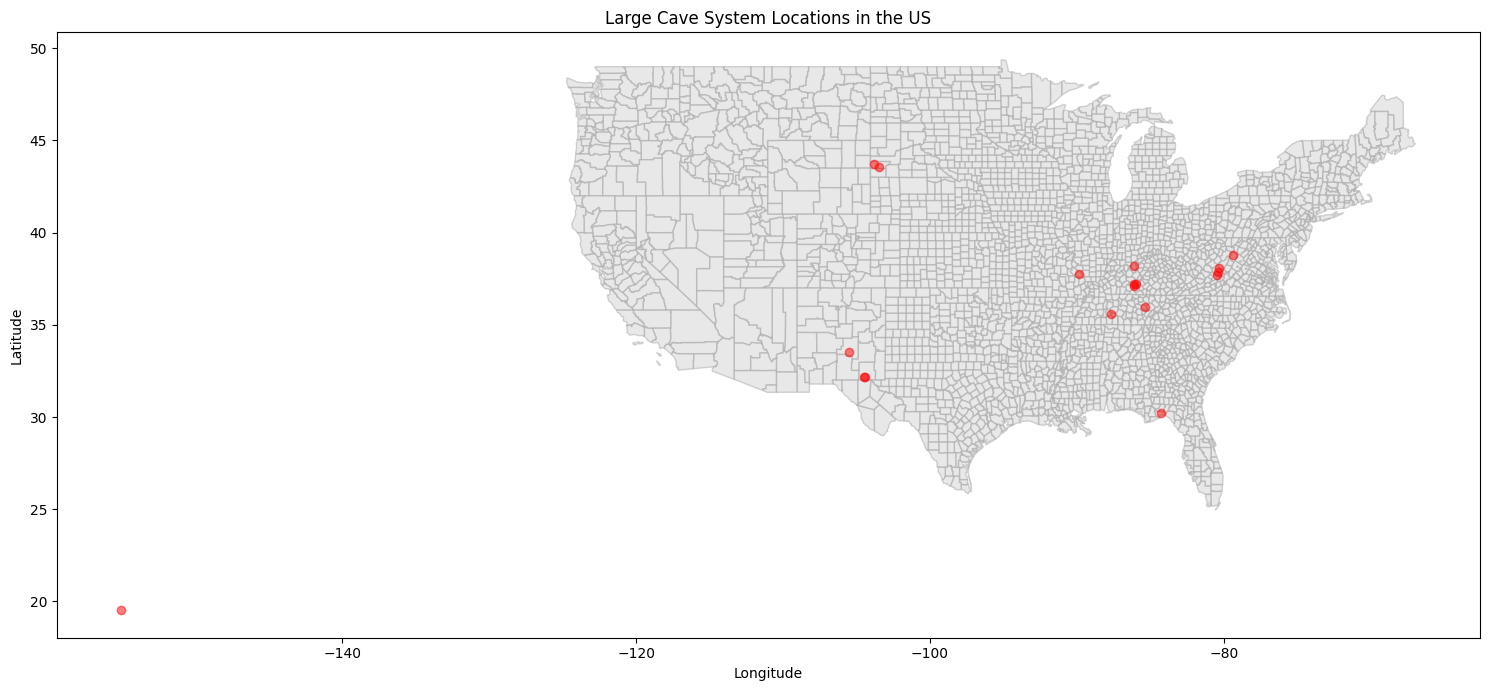

In [401]:
# create a scatter plot with a US map background using geopandas
# Load a base map of the US using geodatasets
us_states_fp = geodatasets.get_path("geoda.natregimes")
usa = gpd.read_file(us_states_fp)

#plotting the map
fig, ax = plt.subplots(figsize=(15,10))
usa.plot(ax=ax, color='lightgrey', edgecolor='darkgrey', alpha=0.5)
ax.scatter(updated_us_cave_systems['longitude'], updated_us_cave_systems['latitude'], color='red', alpha=0.5)
ax.set_title('Large Cave System Locations in the US')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

In [402]:

dogman_sightings = pd.read_csv('dogman_sightings_raw.csv', on_bad_lines='warn')

dogman_sightings


/var/folders/07/95ysvbs12sx3tsnr11h95dvh0000gn/T/ipykernel_55723/2056606790.py:1: ParserWarning: Skipping line 4: expected 3 fields, saw 32

  dogman_sightings = pd.read_csv('dogman_sightings_raw.csv', on_bad_lines='warn')


,title,description,coordinates
0,Canada - Alberta,About three years ago i encountered what I cou...,"\n -116.5765035,53.9332706,0\n"
1,Canada - Deadwood Alberta 1,I came across another report of a bipedal cani...,"\n -117.458219,56.740963,0\n"
2,Canada - Gillam Manitoba,I saw something that put a big scare into me. ...,"\n -94.7748443,56.33341,0\n"
3,Canada - Léry Quebec,An old friend and I cross the path of a dogman...,"\n -73.8059179,45.3444129,0\n ..."
4,Canada - New Brunswick,My grandfather told me this story when I was a...,"\n -66.4619164,46.5653163,0\n ..."
...,...,...,...
125,Texas - Freestone County,4/23/2016 - I was out at my grandparent’s hous...,"\n -96.1526985,31.7534889,0\n ..."
126,Texas - Roscoe,Date Unknown - the first encounter was when i...,"\n -100.5387183,32.445952,0\n ..."
127,Washington - Snohomish County,1997-98 - My first encounter happened late at ...,"\n -122.0981848,47.9128756,0\n ..."
128,Wyoming - Boulder,Name:<br>Ken<br>Report Title:<br>Encounter out...,"\n -109.7205643,42.7461611,0\n ..."


In [403]:
dogman_sightings.describe()

,title,description,coordinates
count,130,130,130
unique,130,130,122
top,Canada - Alberta,About three years ago i encountered what I cou...,"\n -86.2895052,43.643476,0\n"
freq,1,1,2


In [404]:
dogman_sightings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        130 non-null    object
 1   description  130 non-null    object
 2   coordinates  130 non-null    object
dtypes: object(3)
memory usage: 3.2+ KB


In [405]:
dogman_sightings.duplicated().sum()

np.int64(0)

In [406]:
missing_values = dogman_sightings.isnull()

missing_values

print(dogman_sightings.isna().sum())

title          0
description    0
coordinates    0
dtype: int64


In [407]:

# find all NaN values in 'dogman_sightings_raw.csv
dogman_sightings[dogman_sightings['coordinates'].isna()]

dogman_sightings


,title,description,coordinates
0,Canada - Alberta,About three years ago i encountered what I cou...,"\n -116.5765035,53.9332706,0\n"
1,Canada - Deadwood Alberta 1,I came across another report of a bipedal cani...,"\n -117.458219,56.740963,0\n"
2,Canada - Gillam Manitoba,I saw something that put a big scare into me. ...,"\n -94.7748443,56.33341,0\n"
3,Canada - Léry Quebec,An old friend and I cross the path of a dogman...,"\n -73.8059179,45.3444129,0\n ..."
4,Canada - New Brunswick,My grandfather told me this story when I was a...,"\n -66.4619164,46.5653163,0\n ..."
...,...,...,...
125,Texas - Freestone County,4/23/2016 - I was out at my grandparent’s hous...,"\n -96.1526985,31.7534889,0\n ..."
126,Texas - Roscoe,Date Unknown - the first encounter was when i...,"\n -100.5387183,32.445952,0\n ..."
127,Washington - Snohomish County,1997-98 - My first encounter happened late at ...,"\n -122.0981848,47.9128756,0\n ..."
128,Wyoming - Boulder,Name:<br>Ken<br>Report Title:<br>Encounter out...,"\n -109.7205643,42.7461611,0\n ..."


In [408]:
# separate 'title' column into two separate columns, 'city' and 'state
dogman_sightings['city'] = dogman_sightings['title'].str.split(' - ').str[1]

dogman_sightings

,title,description,coordinates,city
0,Canada - Alberta,About three years ago i encountered what I cou...,"\n -116.5765035,53.9332706,0\n",Alberta
1,Canada - Deadwood Alberta 1,I came across another report of a bipedal cani...,"\n -117.458219,56.740963,0\n",Deadwood Alberta 1
2,Canada - Gillam Manitoba,I saw something that put a big scare into me. ...,"\n -94.7748443,56.33341,0\n",Gillam Manitoba
3,Canada - Léry Quebec,An old friend and I cross the path of a dogman...,"\n -73.8059179,45.3444129,0\n ...",Léry Quebec
4,Canada - New Brunswick,My grandfather told me this story when I was a...,"\n -66.4619164,46.5653163,0\n ...",New Brunswick
...,...,...,...,...
125,Texas - Freestone County,4/23/2016 - I was out at my grandparent’s hous...,"\n -96.1526985,31.7534889,0\n ...",Freestone County
126,Texas - Roscoe,Date Unknown - the first encounter was when i...,"\n -100.5387183,32.445952,0\n ...",Roscoe
127,Washington - Snohomish County,1997-98 - My first encounter happened late at ...,"\n -122.0981848,47.9128756,0\n ...",Snohomish County
128,Wyoming - Boulder,Name:<br>Ken<br>Report Title:<br>Encounter out...,"\n -109.7205643,42.7461611,0\n ...",Boulder


In [409]:
# separate 'title' column into two separate columns, 'city' and 'state
dogman_sightings['state'] = dogman_sightings['title'].str.split(' - ').str[0]

dogman_sightings

,title,description,coordinates,city,state
0,Canada - Alberta,About three years ago i encountered what I cou...,"\n -116.5765035,53.9332706,0\n",Alberta,Canada
1,Canada - Deadwood Alberta 1,I came across another report of a bipedal cani...,"\n -117.458219,56.740963,0\n",Deadwood Alberta 1,Canada
2,Canada - Gillam Manitoba,I saw something that put a big scare into me. ...,"\n -94.7748443,56.33341,0\n",Gillam Manitoba,Canada
3,Canada - Léry Quebec,An old friend and I cross the path of a dogman...,"\n -73.8059179,45.3444129,0\n ...",Léry Quebec,Canada
4,Canada - New Brunswick,My grandfather told me this story when I was a...,"\n -66.4619164,46.5653163,0\n ...",New Brunswick,Canada
...,...,...,...,...,...
125,Texas - Freestone County,4/23/2016 - I was out at my grandparent’s hous...,"\n -96.1526985,31.7534889,0\n ...",Freestone County,Texas
126,Texas - Roscoe,Date Unknown - the first encounter was when i...,"\n -100.5387183,32.445952,0\n ...",Roscoe,Texas
127,Washington - Snohomish County,1997-98 - My first encounter happened late at ...,"\n -122.0981848,47.9128756,0\n ...",Snohomish County,Washington
128,Wyoming - Boulder,Name:<br>Ken<br>Report Title:<br>Encounter out...,"\n -109.7205643,42.7461611,0\n ...",Boulder,Wyoming


In [410]:
dogman_sightings['longitude'] = dogman_sightings['coordinates'].str.split(',').str[0]

dogman_sightings

,title,description,coordinates,city,state,longitude
0,Canada - Alberta,About three years ago i encountered what I cou...,"\n -116.5765035,53.9332706,0\n",Alberta,Canada,\n -116.5765035
1,Canada - Deadwood Alberta 1,I came across another report of a bipedal cani...,"\n -117.458219,56.740963,0\n",Deadwood Alberta 1,Canada,\n -117.458219
2,Canada - Gillam Manitoba,I saw something that put a big scare into me. ...,"\n -94.7748443,56.33341,0\n",Gillam Manitoba,Canada,\n -94.7748443
3,Canada - Léry Quebec,An old friend and I cross the path of a dogman...,"\n -73.8059179,45.3444129,0\n ...",Léry Quebec,Canada,\n -73.8059179
4,Canada - New Brunswick,My grandfather told me this story when I was a...,"\n -66.4619164,46.5653163,0\n ...",New Brunswick,Canada,\n -66.4619164
...,...,...,...,...,...,...
125,Texas - Freestone County,4/23/2016 - I was out at my grandparent’s hous...,"\n -96.1526985,31.7534889,0\n ...",Freestone County,Texas,\n -96.1526985
126,Texas - Roscoe,Date Unknown - the first encounter was when i...,"\n -100.5387183,32.445952,0\n ...",Roscoe,Texas,\n -100.5387183
127,Washington - Snohomish County,1997-98 - My first encounter happened late at ...,"\n -122.0981848,47.9128756,0\n ...",Snohomish County,Washington,\n -122.0981848
128,Wyoming - Boulder,Name:<br>Ken<br>Report Title:<br>Encounter out...,"\n -109.7205643,42.7461611,0\n ...",Boulder,Wyoming,\n -109.7205643


In [411]:
dogman_sightings['latitude'] = dogman_sightings['coordinates'].str.split(',').str[1]

dogman_sightings

,title,description,coordinates,city,state,longitude,latitude
0,Canada - Alberta,About three years ago i encountered what I cou...,"\n -116.5765035,53.9332706,0\n",Alberta,Canada,\n -116.5765035,53.9332706
1,Canada - Deadwood Alberta 1,I came across another report of a bipedal cani...,"\n -117.458219,56.740963,0\n",Deadwood Alberta 1,Canada,\n -117.458219,56.740963
2,Canada - Gillam Manitoba,I saw something that put a big scare into me. ...,"\n -94.7748443,56.33341,0\n",Gillam Manitoba,Canada,\n -94.7748443,56.33341
3,Canada - Léry Quebec,An old friend and I cross the path of a dogman...,"\n -73.8059179,45.3444129,0\n ...",Léry Quebec,Canada,\n -73.8059179,45.3444129
4,Canada - New Brunswick,My grandfather told me this story when I was a...,"\n -66.4619164,46.5653163,0\n ...",New Brunswick,Canada,\n -66.4619164,46.5653163
...,...,...,...,...,...,...,...
125,Texas - Freestone County,4/23/2016 - I was out at my grandparent’s hous...,"\n -96.1526985,31.7534889,0\n ...",Freestone County,Texas,\n -96.1526985,31.7534889
126,Texas - Roscoe,Date Unknown - the first encounter was when i...,"\n -100.5387183,32.445952,0\n ...",Roscoe,Texas,\n -100.5387183,32.445952
127,Washington - Snohomish County,1997-98 - My first encounter happened late at ...,"\n -122.0981848,47.9128756,0\n ...",Snohomish County,Washington,\n -122.0981848,47.9128756
128,Wyoming - Boulder,Name:<br>Ken<br>Report Title:<br>Encounter out...,"\n -109.7205643,42.7461611,0\n ...",Boulder,Wyoming,\n -109.7205643,42.7461611


In [412]:
# delete 'title' and 'coordinates' columns
dogman_sightings= dogman_sightings.drop(columns=['title', 'coordinates'])

dogman_sightings

,description,city,state,longitude,latitude
0,About three years ago i encountered what I cou...,Alberta,Canada,\n -116.5765035,53.9332706
1,I came across another report of a bipedal cani...,Deadwood Alberta 1,Canada,\n -117.458219,56.740963
2,I saw something that put a big scare into me. ...,Gillam Manitoba,Canada,\n -94.7748443,56.33341
3,An old friend and I cross the path of a dogman...,Léry Quebec,Canada,\n -73.8059179,45.3444129
4,My grandfather told me this story when I was a...,New Brunswick,Canada,\n -66.4619164,46.5653163
...,...,...,...,...,...
125,4/23/2016 - I was out at my grandparent’s hous...,Freestone County,Texas,\n -96.1526985,31.7534889
126,Date Unknown - the first encounter was when i...,Roscoe,Texas,\n -100.5387183,32.445952
127,1997-98 - My first encounter happened late at ...,Snohomish County,Washington,\n -122.0981848,47.9128756
128,Name:<br>Ken<br>Report Title:<br>Encounter out...,Boulder,Wyoming,\n -109.7205643,42.7461611


In [413]:
dogman_sightings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  130 non-null    object
 1   city         130 non-null    object
 2   state        130 non-null    object
 3   longitude    130 non-null    object
 4   latitude     130 non-null    object
dtypes: object(5)
memory usage: 5.2+ KB


In [414]:
dogman_sightings


,description,city,state,longitude,latitude
0,About three years ago i encountered what I cou...,Alberta,Canada,\n -116.5765035,53.9332706
1,I came across another report of a bipedal cani...,Deadwood Alberta 1,Canada,\n -117.458219,56.740963
2,I saw something that put a big scare into me. ...,Gillam Manitoba,Canada,\n -94.7748443,56.33341
3,An old friend and I cross the path of a dogman...,Léry Quebec,Canada,\n -73.8059179,45.3444129
4,My grandfather told me this story when I was a...,New Brunswick,Canada,\n -66.4619164,46.5653163
...,...,...,...,...,...
125,4/23/2016 - I was out at my grandparent’s hous...,Freestone County,Texas,\n -96.1526985,31.7534889
126,Date Unknown - the first encounter was when i...,Roscoe,Texas,\n -100.5387183,32.445952
127,1997-98 - My first encounter happened late at ...,Snohomish County,Washington,\n -122.0981848,47.9128756
128,Name:<br>Ken<br>Report Title:<br>Encounter out...,Boulder,Wyoming,\n -109.7205643,42.7461611


In [415]:
#change names of 'city' column' to 'city_name' and 'state' to 'state_name' 
dogman_sightings = dogman_sightings.rename(columns={'city': 'city_name', 'state': 'state_name'})

dogman_sightings

,description,city_name,state_name,longitude,latitude
0,About three years ago i encountered what I cou...,Alberta,Canada,\n -116.5765035,53.9332706
1,I came across another report of a bipedal cani...,Deadwood Alberta 1,Canada,\n -117.458219,56.740963
2,I saw something that put a big scare into me. ...,Gillam Manitoba,Canada,\n -94.7748443,56.33341
3,An old friend and I cross the path of a dogman...,Léry Quebec,Canada,\n -73.8059179,45.3444129
4,My grandfather told me this story when I was a...,New Brunswick,Canada,\n -66.4619164,46.5653163
...,...,...,...,...,...
125,4/23/2016 - I was out at my grandparent’s hous...,Freestone County,Texas,\n -96.1526985,31.7534889
126,Date Unknown - the first encounter was when i...,Roscoe,Texas,\n -100.5387183,32.445952
127,1997-98 - My first encounter happened late at ...,Snohomish County,Washington,\n -122.0981848,47.9128756
128,Name:<br>Ken<br>Report Title:<br>Encounter out...,Boulder,Wyoming,\n -109.7205643,42.7461611


In [416]:
# find date in 'description' column and create new 'date' column
dogman_sightings['date'] = dogman_sightings['description'].str.extract(r'(\d{1,2}/\d{1,2}/\d{4})')
dogman_sightings

# show all rows in output
pd.set_option('display.max_rows', None)

# show default rows
pd.set_option('display.max_rows', 10)

dogman_sightings

,description,city_name,state_name,longitude,latitude,date
0,About three years ago i encountered what I cou...,Alberta,Canada,\n -116.5765035,53.9332706,NaN
1,I came across another report of a bipedal cani...,Deadwood Alberta 1,Canada,\n -117.458219,56.740963,NaN
2,I saw something that put a big scare into me. ...,Gillam Manitoba,Canada,\n -94.7748443,56.33341,NaN
3,An old friend and I cross the path of a dogman...,Léry Quebec,Canada,\n -73.8059179,45.3444129,NaN
4,My grandfather told me this story when I was a...,New Brunswick,Canada,\n -66.4619164,46.5653163,NaN
...,...,...,...,...,...,...
125,4/23/2016 - I was out at my grandparent’s hous...,Freestone County,Texas,\n -96.1526985,31.7534889,4/23/2016
126,Date Unknown - the first encounter was when i...,Roscoe,Texas,\n -100.5387183,32.445952,NaN
127,1997-98 - My first encounter happened late at ...,Snohomish County,Washington,\n -122.0981848,47.9128756,NaN
128,Name:<br>Ken<br>Report Title:<br>Encounter out...,Boulder,Wyoming,\n -109.7205643,42.7461611,10/15/2010


In [417]:
def season(description): 
    description = description.lower()
    if 'january' in description or 'february' in description or 'december'in description:
        return 'Winter'
    elif 'march' in description or 'april' in description or 'may' in description:
        return 'Spring'
    elif 'june' in description or 'july' in description or 'august' in description:
        return 'Summer'
    elif 'september' in description or 'october' in description or 'november'in description:
        return 'Fall'
    else:
        return 'Unknown' 
        
dogman_sightings['season'] = dogman_sightings['description'].apply(season)          

dogman_sightings

,description,city_name,state_name,longitude,latitude,date,season
0,About three years ago i encountered what I cou...,Alberta,Canada,\n -116.5765035,53.9332706,NaN,Unknown
1,I came across another report of a bipedal cani...,Deadwood Alberta 1,Canada,\n -117.458219,56.740963,NaN,Spring
2,I saw something that put a big scare into me. ...,Gillam Manitoba,Canada,\n -94.7748443,56.33341,NaN,Summer
3,An old friend and I cross the path of a dogman...,Léry Quebec,Canada,\n -73.8059179,45.3444129,NaN,Spring
4,My grandfather told me this story when I was a...,New Brunswick,Canada,\n -66.4619164,46.5653163,NaN,Unknown
...,...,...,...,...,...,...,...
125,4/23/2016 - I was out at my grandparent’s hous...,Freestone County,Texas,\n -96.1526985,31.7534889,4/23/2016,Unknown
126,Date Unknown - the first encounter was when i...,Roscoe,Texas,\n -100.5387183,32.445952,NaN,Spring
127,1997-98 - My first encounter happened late at ...,Snohomish County,Washington,\n -122.0981848,47.9128756,NaN,Spring
128,Name:<br>Ken<br>Report Title:<br>Encounter out...,Boulder,Wyoming,\n -109.7205643,42.7461611,10/15/2010,Unknown


In [418]:
dogman_sightings


,description,city_name,state_name,longitude,latitude,date,season
0,About three years ago i encountered what I cou...,Alberta,Canada,\n -116.5765035,53.9332706,NaN,Unknown
1,I came across another report of a bipedal cani...,Deadwood Alberta 1,Canada,\n -117.458219,56.740963,NaN,Spring
2,I saw something that put a big scare into me. ...,Gillam Manitoba,Canada,\n -94.7748443,56.33341,NaN,Summer
3,An old friend and I cross the path of a dogman...,Léry Quebec,Canada,\n -73.8059179,45.3444129,NaN,Spring
4,My grandfather told me this story when I was a...,New Brunswick,Canada,\n -66.4619164,46.5653163,NaN,Unknown
...,...,...,...,...,...,...,...
125,4/23/2016 - I was out at my grandparent’s hous...,Freestone County,Texas,\n -96.1526985,31.7534889,4/23/2016,Unknown
126,Date Unknown - the first encounter was when i...,Roscoe,Texas,\n -100.5387183,32.445952,NaN,Spring
127,1997-98 - My first encounter happened late at ...,Snohomish County,Washington,\n -122.0981848,47.9128756,NaN,Spring
128,Name:<br>Ken<br>Report Title:<br>Encounter out...,Boulder,Wyoming,\n -109.7205643,42.7461611,10/15/2010,Unknown


In [419]:

# round latitude and longitude columns to 5 decimal places
dogman_sightings['latitude'] = dogman_sightings['latitude'].astype(float).round(5)
dogman_sightings['longitude'] = dogman_sightings['longitude'].astype(float).round(5)    

dogman_sightings


,description,city_name,state_name,longitude,latitude,date,season
0,About three years ago i encountered what I cou...,Alberta,Canada,-116.57650,53.93327,NaN,Unknown
1,I came across another report of a bipedal cani...,Deadwood Alberta 1,Canada,-117.45822,56.74096,NaN,Spring
2,I saw something that put a big scare into me. ...,Gillam Manitoba,Canada,-94.77484,56.33341,NaN,Summer
3,An old friend and I cross the path of a dogman...,Léry Quebec,Canada,-73.80592,45.34441,NaN,Spring
4,My grandfather told me this story when I was a...,New Brunswick,Canada,-66.46192,46.56532,NaN,Unknown
...,...,...,...,...,...,...,...
125,4/23/2016 - I was out at my grandparent’s hous...,Freestone County,Texas,-96.15270,31.75349,4/23/2016,Unknown
126,Date Unknown - the first encounter was when i...,Roscoe,Texas,-100.53872,32.44595,NaN,Spring
127,1997-98 - My first encounter happened late at ...,Snohomish County,Washington,-122.09818,47.91288,NaN,Spring
128,Name:<br>Ken<br>Report Title:<br>Encounter out...,Boulder,Wyoming,-109.72056,42.74616,10/15/2010,Unknown


In [420]:
# Step 1: Convert to string and handle NaN
dogman_sightings['longitude'] = dogman_sightings['longitude'].fillna('').astype(str)

# Step 2: Use str accessor
dogman_sightings['longitude_clean'] = dogman_sightings['longitude'].str.len()

dogman_sightings

,description,city_name,state_name,longitude,latitude,date,season,longitude_clean
0,About three years ago i encountered what I cou...,Alberta,Canada,-116.5765,53.93327,NaN,Unknown,9
1,I came across another report of a bipedal cani...,Deadwood Alberta 1,Canada,-117.45822,56.74096,NaN,Spring,10
2,I saw something that put a big scare into me. ...,Gillam Manitoba,Canada,-94.77484,56.33341,NaN,Summer,9
3,An old friend and I cross the path of a dogman...,Léry Quebec,Canada,-73.80592,45.34441,NaN,Spring,9
4,My grandfather told me this story when I was a...,New Brunswick,Canada,-66.46192,46.56532,NaN,Unknown,9
...,...,...,...,...,...,...,...,...
125,4/23/2016 - I was out at my grandparent’s hous...,Freestone County,Texas,-96.1527,31.75349,4/23/2016,Unknown,8
126,Date Unknown - the first encounter was when i...,Roscoe,Texas,-100.53872,32.44595,NaN,Spring,10
127,1997-98 - My first encounter happened late at ...,Snohomish County,Washington,-122.09818,47.91288,NaN,Spring,10
128,Name:<br>Ken<br>Report Title:<br>Encounter out...,Boulder,Wyoming,-109.72056,42.74616,10/15/2010,Unknown,10


In [421]:
# add new column 'dogman_sighting_id' with unique identifier for each row and making it the first column
dogman_sightings.insert(0, 'dogman_sighting_id', range(1, 1 + len(dogman_sightings)))

dogman_sightings

,dogman_sighting_id,description,city_name,state_name,longitude,latitude,date,season,longitude_clean
0,1,About three years ago i encountered what I cou...,Alberta,Canada,-116.5765,53.93327,NaN,Unknown,9
1,2,I came across another report of a bipedal cani...,Deadwood Alberta 1,Canada,-117.45822,56.74096,NaN,Spring,10
2,3,I saw something that put a big scare into me. ...,Gillam Manitoba,Canada,-94.77484,56.33341,NaN,Summer,9
3,4,An old friend and I cross the path of a dogman...,Léry Quebec,Canada,-73.80592,45.34441,NaN,Spring,9
4,5,My grandfather told me this story when I was a...,New Brunswick,Canada,-66.46192,46.56532,NaN,Unknown,9
...,...,...,...,...,...,...,...,...,...
125,126,4/23/2016 - I was out at my grandparent’s hous...,Freestone County,Texas,-96.1527,31.75349,4/23/2016,Unknown,8
126,127,Date Unknown - the first encounter was when i...,Roscoe,Texas,-100.53872,32.44595,NaN,Spring,10
127,128,1997-98 - My first encounter happened late at ...,Snohomish County,Washington,-122.09818,47.91288,NaN,Spring,10
128,129,Name:<br>Ken<br>Report Title:<br>Encounter out...,Boulder,Wyoming,-109.72056,42.74616,10/15/2010,Unknown,10


In [422]:
dogman_sightings = dogman_sightings.rename(columns={'sight_date': 'sighting_date'})
dogman_sightings

,dogman_sighting_id,description,city_name,state_name,longitude,latitude,date,season,longitude_clean
0,1,About three years ago i encountered what I cou...,Alberta,Canada,-116.5765,53.93327,NaN,Unknown,9
1,2,I came across another report of a bipedal cani...,Deadwood Alberta 1,Canada,-117.45822,56.74096,NaN,Spring,10
2,3,I saw something that put a big scare into me. ...,Gillam Manitoba,Canada,-94.77484,56.33341,NaN,Summer,9
3,4,An old friend and I cross the path of a dogman...,Léry Quebec,Canada,-73.80592,45.34441,NaN,Spring,9
4,5,My grandfather told me this story when I was a...,New Brunswick,Canada,-66.46192,46.56532,NaN,Unknown,9
...,...,...,...,...,...,...,...,...,...
125,126,4/23/2016 - I was out at my grandparent’s hous...,Freestone County,Texas,-96.1527,31.75349,4/23/2016,Unknown,8
126,127,Date Unknown - the first encounter was when i...,Roscoe,Texas,-100.53872,32.44595,NaN,Spring,10
127,128,1997-98 - My first encounter happened late at ...,Snohomish County,Washington,-122.09818,47.91288,NaN,Spring,10
128,129,Name:<br>Ken<br>Report Title:<br>Encounter out...,Boulder,Wyoming,-109.72056,42.74616,10/15/2010,Unknown,10


In [423]:
# create location_id column with unique identifier using a range in all datasets
def create_location_id(df):
    df['location_id'] = range(1, 1 + len(df))
    return df

victims_coords['location_id'] = range(1, 1 + len(victims_coords))
bfro_locations['location_id'] = range(1, 1 + len(bfro_locations))
dogman_sightings['location_id'] = range(1, 1 + len(dogman_sightings))
updated_us_cave_systems['location_id'] = range(1, 1 + len(updated_us_cave_systems))

In [424]:
dogman_sightings

,dogman_sighting_id,description,city_name,state_name,longitude,latitude,date,season,longitude_clean,location_id
0,1,About three years ago i encountered what I cou...,Alberta,Canada,-116.5765,53.93327,NaN,Unknown,9,1
1,2,I came across another report of a bipedal cani...,Deadwood Alberta 1,Canada,-117.45822,56.74096,NaN,Spring,10,2
2,3,I saw something that put a big scare into me. ...,Gillam Manitoba,Canada,-94.77484,56.33341,NaN,Summer,9,3
3,4,An old friend and I cross the path of a dogman...,Léry Quebec,Canada,-73.80592,45.34441,NaN,Spring,9,4
4,5,My grandfather told me this story when I was a...,New Brunswick,Canada,-66.46192,46.56532,NaN,Unknown,9,5
...,...,...,...,...,...,...,...,...,...,...
125,126,4/23/2016 - I was out at my grandparent’s hous...,Freestone County,Texas,-96.1527,31.75349,4/23/2016,Unknown,8,126
126,127,Date Unknown - the first encounter was when i...,Roscoe,Texas,-100.53872,32.44595,NaN,Spring,10,127
127,128,1997-98 - My first encounter happened late at ...,Snohomish County,Washington,-122.09818,47.91288,NaN,Spring,10,128
128,129,Name:<br>Ken<br>Report Title:<br>Encounter out...,Boulder,Wyoming,-109.72056,42.74616,10/15/2010,Unknown,10,129


In [425]:

# Step 1: Establish a connection to the SQLite database
conn = sqlite3.connect('sightings_database.db')

# close the connection
conn.close()

In [426]:

conn = sqlite3.connect('sightings_database.db')

# Step 3: Load each DataFrame into SQLite as a separate table
bfro_locations.to_sql('BigfootSightings', conn, if_exists='replace', index=False)
dogman_sightings.to_sql('DogmanSightings', conn, if_exists='replace', index=False)
victims_coords.to_sql('MissingPersons', conn, if_exists='replace', index=False)
updated_us_cave_systems.to_sql('CaveSystems', conn, if_exists='replace', index=False)



19

In [427]:
conn = sqlite3.connect('sightings_database.db')

# create all four table with selected columns
BigfootSightings_df = bfro_locations[['bigfoot_sighting_id', 'description', 'classification', 'timestamp', 'latitude', 'longitude', 'location_id']]
BigfootSightings_df.to_sql('BigfootSightings', conn, if_exists='replace', index=False)

DogmanSightings_df = dogman_sightings[['dogman_sighting_id', 'description', 'city_name', 'state_name', 'longitude', 'latitude', 'date', 'season', 'location_id']]
DogmanSightings_df.to_sql('DogmanSightings', conn, if_exists='replace', index=False)

MissingPersons_df = victims_coords[['missing_persons_id', 'victim_name', 'age', 'park_name', 'state_name', 'year', 'latitude', 'longitude', 'location_id']]
MissingPersons_df.to_sql('MissingPersons', conn, if_exists='replace', index=False)

CaveSystems_df = updated_us_cave_systems[['cave_system_id', 'cave_name', 'length', 'associated_park_restricted_area', 'access', 'latitude', 'longitude', 'city_name', 'state_name', 'location_id']]   

conn.commit()

In [428]:
# create Locations table
parks_query = '''
CREATE TABLE IF NOT EXISTS Parks (
    park_id INTEGER PRIMARY KEY,
    location_id INTEGER,
    victim_name TEXT,
    park_name TEXT,
    latitude REAL,
    longitude REAL,
    FOREIGN KEY (location_id) REFERENCES Locations(location_id)  -- Assuming Locations table exists
);  
'''
conn.execute(parks_query)




# Insert one row per park_name from MissingPersons.
# Use aggregate functions to pick a representative location and avoid duplicates.
# INSERT OR IGNORE ensures no error if a park row already exists.
insert_query = '''
INSERT OR IGNORE INTO Parks (location_id, victim_name, park_name, latitude, longitude)
SELECT
    MIN(location_id) AS location_id,
    NULL AS victim_name,
    park_name,
    MIN(latitude) AS latitude,
    MIN(longitude) AS longitude
FROM MissingPersons
GROUP BY park_name;
'''

conn.execute(insert_query)
conn.commit()



In [429]:
# Have any dogman sightings been reported in the same locations as bigfoot sightings?
conn = sqlite3.connect('sightings_database.db')

query1 = '''
SELECT
    b.bigfoot_sighting_id,
    d.dogman_sighting_id,
    b.latitude AS bigfoot_latitude,     
    b.longitude AS bigfoot_longitude,
    d.latitude AS dogman_latitude,     
    d.longitude AS dogman_longitude
FROM
    BigfootSightings b
JOIN
    DogmanSightings d ON b.latitude = d.latitude AND b.longitude = d.longitude
WHERE 
    b.latitude = d.latitude AND b.longitude = d.longitude;
'''

result1 = pd.read_sql(query1, conn)
result1

,bigfoot_sighting_id,dogman_sighting_id,bigfoot_latitude,bigfoot_longitude,dogman_latitude,dogman_longitude


In [430]:
conn = sqlite3.connect('sightings_database.db')

# view the latitude column data from CaveSystems table
query2 = '''
SELECT
    longitude,
    latitude
FROM
    CaveSystems;
''' 
result2 = pd.read_sql(query2, conn)
result2

,longitude,latitude
0,-86.103570,37.187580
1,-103.829440,43.729440
2,-103.479550,43.558040
3,-104.503309,32.190642
4,-85.975100,37.187300
...,...,...
14,-104.441039,32.177057
15,-80.436298,37.718156
16,-84.302875,30.235415
17,-86.136200,37.119600


In [431]:

conn = sqlite3.connect('sightings_database.db') 
# update DogmanSightings table in database with cleaned latitude and longitude values
dogman_sightings.to_sql('DogmanSightings', conn, if_exists='replace', index=False)      




130

In [432]:
import re
def dms_to_dd(d, m, s, hem):
    dd = float(d) + float(m) / 60 + float(s) / 3600
    if hem.upper() in ('S', 'W'):
        dd = -dd
    return dd

# regexes to match decimal degrees with direction, plain signed decimals, and DMS
dec_with_dir = re.compile(r'([0-9]{1,3}\.\d+)[°\s]*([NnSs]).*?([0-9]{1,3}\.\d+)[°\s]*([EeWw])')
signed_dec = re.compile(r'-?\d+\.\d+')
dms_pair = re.compile(r'(\d{1,3})[°\s]+(\d{1,2})[\'′\s]+(\d{1,2}(?:\.\d+)?)[\"″\s]*([NnSsEeWw])')

def parse_coordinates(s):
    if pd.isna(s):
        return pd.Series([np.nan, np.nan])

    # 1) decimal degrees with N/S and E/W (e.g. "37.18758°N 86.10357°W")
    m = dec_with_dir.search(s)
    if m:
        lat = float(m.group(1)) * (1 if m.group(2).upper() == 'N' else -1)
        lon = float(m.group(3)) * (1 if m.group(4).upper() == 'E' else -1)
        return pd.Series([lat, lon])

    # 2) any two signed decimals appearing in the string (heuristic)
    nums = signed_dec.findall(s)
    if len(nums) >= 2:
        a, b = map(float, nums[:2])
        # heuristic: latitude must be within [-90, 90]
        if abs(a) <= 90 and abs(b) <= 180:
            return pd.Series([a, b])
        if abs(b) <= 90 and abs(a) <= 180:
            return pd.Series([b, a])
        return pd.Series([np.nan, np.nan])

    # 3) try parsing two DMS occurrences (degree/min/sec + direction)
    dms_matches = dms_pair.findall(s)
    if len(dms_matches) >= 2:
        lat = dms_to_dd(dms_matches[0][0], dms_matches[0][1], dms_matches[0][2], dms_matches[0][3])
        lon = dms_to_dd(dms_matches[1][0], dms_matches[1][1], dms_matches[1][2], dms_matches[1][3])
        return pd.Series([lat, lon])

    return pd.Series([np.nan, np.nan])

# parse and write back into the dataframe
updated_us_cave_systems[['latitude_parsed', 'longitude_parsed']] = updated_us_cave_systems['Coordinates'].apply(parse_coordinates)

# fill the missing latitude (was all NaN) and clean/merge longitude
updated_us_cave_systems['latitude'] = updated_us_cave_systems['latitude_parsed']


# try to extract a clean numeric longitude from the existing 'longitude' column, otherwise use parsed
existing_lon_num = updated_us_cave_systems['longitude'].astype(str).str.extract(r'(-?\d+\.\d+)')[0].astype(float)
updated_us_cave_systems['longitude'] = existing_lon_num.fillna(updated_us_cave_systems['longitude_parsed'])

# drop helper columns
updated_us_cave_systems.drop(columns=['latitude_parsed', 'longitude_parsed'], inplace=True)

# show results
updated_us_cave_systems[['Coordinates', 'latitude', 'longitude']]

,Coordinates,latitude,longitude
0,37°11′15″N86°06′13″W﻿ / ﻿37.18758°N 86.10357°W...,37.187580,-86.103570
1,43°43′46″N103°49′46″W﻿ / ﻿43.72944°N 103.82944...,43.729440,-103.829440
2,43°33′29″N103°28′46″W﻿ / ﻿43.55804°N 103.47955...,43.558040,-103.479550
3,32°11′26″N104°30′12″W﻿ / ﻿32.1906420°N 104.503...,32.190642,-104.503309
4,37°11′14″N85°58′30″W﻿ / ﻿37.1873°N 85.9751°W﻿ ...,37.187300,-85.975100
...,...,...,...
14,32°10′37″N104°26′28″W﻿ / ﻿32.177057°N 104.4410...,32.177057,-104.441039
15,37°43′05″N80°26′11″W﻿ / ﻿37.7181564°N 80.43629...,37.718156,-80.436298
16,30°14′07″N84°18′10″W﻿ / ﻿30.2354147°N 84.30287...,30.235415,-84.302875
17,37°07′11″N86°08′10″W﻿ / ﻿37.1196°N 86.1362°W﻿ ...,37.119600,-86.136200


In [433]:
# round latitude and longitude columns to 5 decimal places
updated_us_cave_systems['latitude'] = updated_us_cave_systems['latitude'].astype(float).round(5)
updated_us_cave_systems['longitude'] =updated_us_cave_systems['longitude'].astype(float).round(5) 

In [434]:
# round latitude and longitude columns to 5 decimal places
victims_coords['latitude'] = victims_coords['latitude'].astype(float).round(5)
victims_coords['longitude'] = victims_coords['longitude'].astype(float).round(5)    


In [435]:
# round latitude and longitude columns to 5 decimal places
bfro_locations['latitude'] = bfro_locations['latitude'].astype(float).round(5)
bfro_locations['longitude'] = bfro_locations['longitude'].astype(float).round(5)    


In [436]:
# update CaveSystems table in database with cleaned latitude and longitude values
updated_us_cave_systems.to_sql('C', conn, if_exists='replace', index=False)      

conn.close()

In [437]:
# update MissingPersons table in database with cleaned latitude and longitude values
conn = sqlite3.connect('sightings_database.db')
victims_coords.to_sql('MissingPersons', conn, if_exists='replace', index=False)      



261

In [438]:
# update CaveSystems table in database with cleaned latitude and longitude values
updated_us_cave_systems.to_sql('CaveSystems', conn, if_exists='replace', index=False) 

19

In [439]:
# view the latitude column data from updated tables
query2 = '''
SELECT
    longitude,
    latitude
FROM
    BigfootSightings;
''' 
result2 = pd.read_sql(query2, conn)
result2

conn.close()

In [440]:
conn = sqlite3.connect('sightings_database.db')
# update BigfootSightings table in database with cleaned latitude and longitude values
bfro_locations.to_sql('BigfootSightings', conn, if_exists='replace', index=False) 

4309

In [441]:
conn.close()

In [442]:
conn = sqlite3.connect('sightings_database.db')

# how many bigfoot sightings have occured near cave systems (within 0.1 degree lat/lon)?
query3 = '''
SELECT
    b.bigfoot_sighting_id,
    c.cave_system_id,
    b.latitude AS bigfoot_latitude,     
    b.longitude AS bigfoot_longitude,
    c.latitude AS cave_latitude,     
    c.longitude AS cave_longitude
FROM
    BigfootSightings b
JOIN
    CaveSystems c ON ABS(b.latitude - c.latitude) <= 0.1 AND ABS(b.longitude - c.longitude) <= 0.1
WHERE 
    ABS(b.latitude - c.latitude) <= 0.1 AND ABS(b.longitude - c.longitude) <= 0.1;
''' 
result3 = pd.read_sql(query3, conn)
result3

,bigfoot_sighting_id,cave_system_id,bigfoot_latitude,bigfoot_longitude,cave_latitude,cave_longitude
0,19841,11,38.8350,-79.3762,38.77136,-79.37810
1,20101,11,38.8350,-79.3686,38.77136,-79.37810
2,20846,11,38.8409,-79.4016,38.77136,-79.37810
3,23762,9,37.9937,-80.3616,38.06720,-80.32978
4,6632,1,37.1496,-86.0163,37.18758,-86.10357
5,6632,5,37.1496,-86.0163,37.18730,-85.97510
6,8796,11,38.8554,-79.3999,38.77136,-79.37810


In [443]:
# how many dogman sightings have occured near cave systems (within 0.1 degree lat/lon)?
query4 = '''
SELECT
    d.dogman_sighting_id,
    c.cave_system_id,
    d.latitude AS dogman_latitude,
    d.longitude AS dogman_longitude,
    c.latitude AS cave_latitude,     
    c.longitude AS cave_longitude
FROM
    DogmanSightings d
JOIN
    CaveSystems c ON ABS(d.latitude - c.latitude) <= 0.1 AND ABS(d.longitude - c.longitude) <+0.1
WHERE
    ABS(d.latitude - c.latitude) <= 0.1 AND ABS(d.longitude - c.longitude) <= 0.1;
'''
result4 = pd.read_sql(query4, conn)
result4

,dogman_sighting_id,cave_system_id,dogman_latitude,dogman_longitude,cave_latitude,cave_longitude


In [444]:
# dogman sightings near bigfoot sightings (within 0.2 degree lat/lon)?
query5 = '''
SELECT
    b.bigfoot_sighting_id,
    d.dogman_sighting_id,
    b.latitude AS bigfoot_latitude,     
    b.longitude AS bigfoot_longitude,
    d.latitude AS dogman_latitude,     
    d.longitude AS dogman_longitude
FROM
    BigfootSightings b
JOIN
    DogmanSightings d ON ABS(b.latitude - d.latitude) <= 0.2 AND ABS(b.longitude - d.longitude) <= 0.2
WHERE 
    ABS(b.latitude - d.latitude) <= 0.2 AND ABS(b.longitude - d.longitude) <= 0.2;
'''
result5 = pd.read_sql(query5, conn)
result5

,bigfoot_sighting_id,dogman_sighting_id,bigfoot_latitude,bigfoot_longitude,dogman_latitude,dogman_longitude
0,1022,57,33.97575,-87.45876,33.85636,-87.30161
1,6178,102,36.18333,-94.44694,36.26615,-94.47998
2,5702,58,30.48360,-84.20835,30.49062,-84.18571
3,2219,67,34.64230,-83.41920,34.64789,-83.54966
4,7237,67,34.67200,-83.71400,34.64789,-83.54966
...,...,...,...,...,...,...
257,39858,128,48.08350,-121.96830,47.91288,-122.09818
258,44489,128,47.84650,-122.13570,47.91288,-122.09818
259,9980,52,45.94000,-90.46000,45.75117,-90.46221
260,43648,51,43.42500,-88.68000,43.50436,-88.62414


In [445]:
query5 = '''
SELECT
    b.bigfoot_sighting_id,
    d.dogman_sighting_id,
    c.cave_name,
    b.latitude AS bigfoot_latitude, 
    b.longitude AS bigfoot_longitude,
    d.latitude AS dogman_latitude,     
    d.longitude AS dogman_longitude,
    c.latitude AS cave_latitude,     
    c.longitude AS cave_longitude
FROM
    BigfootSightings b
JOIN
    DogmanSightings d ON ABS(b.latitude - d.latitude) <= 0.2 AND ABS(b.longitude - d.longitude) <= 0.2
JOIN
    Cavesystems c ON ABS(b.latitude - c.latitude) <= 0.2 AND ABS(b.longitude - c.longitude) <= 0.2
WHERE 
    ABS(b.latitude - d.latitude) <= 0.2 AND ABS(b.longitude - d.longitude) <= 0.2;
'''
result5 = pd.read_sql(query5, conn)
result5

,bigfoot_sighting_id,dogman_sighting_id,cave_name,bigfoot_latitude,bigfoot_longitude,dogman_latitude,dogman_longitude,cave_latitude,cave_longitude


In [446]:
ufo_sightings_transformed = pd.read_csv('ufo_sightings_transformed.csv')

ufo_sightings_transformed

,ufo_sighting_id,Date_time,date_documented,Year,Month,Hour,Season,Country_Code,Country,Region,Locale,latitude,longitude,UFO_shape,length_of_encounter_seconds,Encounter_Duration,Description
0,0,1949-10-10 20:30:00,4/27/2004,1949,10,20,Autumn,USA,United States,Texas,San Marcos,29.883056,-97.941111,Cylinder,2700.0,45 minutes,This event took place in early fall around 194...
1,1,1949-10-10 21:00:00,12/16/2005,1949,10,21,Autumn,USA,United States,Texas,Bexar County,29.384210,-98.581082,Light,7200.0,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...
2,2,1955-10-10 17:00:00,1/21/2008,1955,10,17,Autumn,GBR,United Kingdom,England,Chester,53.200000,-2.916667,Circle,20.0,20 seconds,Green/Orange circular disc over Chester&#44 En...
3,3,1956-10-10 21:00:00,1/17/2004,1956,10,21,Autumn,USA,United States,Texas,Edna,28.978333,-96.645833,Circle,20.0,1/2 hour,My older brother and twin sister were leaving ...
4,4,1960-10-10 20:00:00,1/22/2004,1960,10,20,Autumn,USA,United States,Hawaii,Kaneohe,21.418056,-157.803611,Light,900.0,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80323,80323,2013-09-09 21:15:00,9/30/2013,2013,9,21,Autumn,USA,United States,Tennessee,Nashville,36.165833,-86.784444,Light,600.0,10 minutes,Round from the distance/slowly changing colors...
80324,80324,2013-09-09 22:00:00,9/30/2013,2013,9,22,Autumn,USA,United States,Idaho,Boise,43.613611,-116.202500,Circle,1200.0,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...
80325,80325,2013-09-09 22:00:00,9/30/2013,2013,9,22,Autumn,USA,United States,California,Napa Abajo,38.297222,-122.284444,Other,1200.0,hour,Napa UFO&#44
80326,80326,2013-09-09 22:20:00,9/30/2013,2013,9,22,Autumn,USA,United States,Virginia,Vienna,38.901111,-77.265556,Circle,5.0,5 seconds,Saw a five gold lit cicular craft moving fastl...


In [447]:
ufo_sightings_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80328 entries, 0 to 80327
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ufo_sighting_id              80328 non-null  int64  
 1   Date_time                    80328 non-null  object 
 2   date_documented              80328 non-null  object 
 3   Year                         80328 non-null  int64  
 4   Month                        80328 non-null  int64  
 5   Hour                         80328 non-null  int64  
 6   Season                       80328 non-null  object 
 7   Country_Code                 80069 non-null  object 
 8   Country                      80069 non-null  object 
 9   Region                       79762 non-null  object 
 10  Locale                       79871 non-null  object 
 11  latitude                     80328 non-null  float64
 12  longitude                    80328 non-null  float64
 13  UFO_shape       

In [448]:
missing_values = ufo_sightings_transformed.isnull()
missing_values

ufo_sightings_transformed.isna().sum()

ufo_sighting_id                   0
Date_time                         0
date_documented                   0
Year                              0
Month                             0
                               ... 
longitude                         0
UFO_shape                      1930
length_of_encounter_seconds       0
Encounter_Duration                0
Description                      15
Length: 17, dtype: int64

In [449]:
bfro_locations['sighting_date'] = bfro_locations['timestamp'].str.split(' T ').str[0]

# need to delete the T in between date and time in sighting_time column  
bfro_locations['sighting_date'] = bfro_locations['sighting_date'].str.replace('T', ' ')
bfro_locations['sighting_date'] = bfro_locations['sighting_date'].str.replace('Z', '')

# create new column 'sighting_time' by splitting the 'sighting_date' column and extracting the time portion
bfro_locations['sighting_time'] = bfro_locations['sighting_date'].str.split(' ').str[1]

# delete time portion from 'sighting_date' column
bfro_locations['sighting_date'] = bfro_locations['sighting_date'].str.split(' ').str[0]

# convert 'sighting_date' column to datetime format
bfro_locations['sighting_date'] = pd.to_datetime(bfro_locations['sighting_date'], errors='coerce')

bfro_locations.drop(columns=['timestamp'], inplace=True )



bfro_locations



,bigfoot_sighting_id,description,classification,latitude,longitude,location_id,sighting_date,sighting_time
0,637,Report 637: Campers' encounter just after dark...,Class A,61.50000,-142.90000,1,2000-06-16,12:00:00
1,2917,Report 2917: Family observes large biped from car,Class A,55.18720,-132.79820,2,1995-05-15,12:00:00
2,7963,Report 7963: Sasquatch walks past window of ho...,Class A,55.20350,-132.82020,3,2004-02-09,12:00:00
3,9317,"Report 9317: Driver on Alcan Highway has noon,...",Class A,62.93750,-141.56670,4,2004-06-18,12:00:00
4,13038,Report 13038: Snowmobiler has encounter in dee...,Class A,61.05950,-149.78530,5,2004-02-15,12:00:00
...,...,...,...,...,...,...,...,...
4304,4159,Report 4159: Campers hear unusual grunting sou...,Class C,31.22333,-94.96611,4305,1995-11-15,12:00:00
4305,175,Report 175: Campers encounter large animal nea...,Class C,47.47745,-121.04150,4306,2000-07-30,12:00:00
4306,945,Report 945: Creature with red glowing eyes seen,Class C,47.57778,-124.29330,4307,1999-03-19,12:00:00
4307,1387,Report 1387: Father and son hear heavy footste...,Class C,47.51030,-122.04560,4308,1983-08-17,12:00:00


In [450]:
# update BigfootSightings table in database with cleaned sighting_date and sighting_time values and dropped timestamp column
conn = sqlite3.connect('sightings_database.db')
bfro_locations.to_sql('BigfootSightings', conn, if_exists='replace', index=False)

4309

In [451]:
# create new column 'sighting_date' by splitting the 'Date_time' column and extracting the time portion
ufo_sightings_transformed['sighting_date'] = ufo_sightings_transformed['Date_time'].str.split(' ').str[0]

ufo_sightings_transformed['sighting_time'] = ufo_sightings_transformed['Date_time'].str.split(' ').str[1]




In [452]:
# round latitude and longitude columns to 5 decimal places
ufo_sightings_transformed['latitude'] = ufo_sightings_transformed['latitude'].astype(float).round(5)
ufo_sightings_transformed['longitude'] = ufo_sightings_transformed['longitude'].astype(float).round(5) 

ufo_sightings_transformed.drop(columns=['Date_time', 'Year', 'Month', 'length_of_encounter_seconds'], inplace=True)



In [453]:
ufo_sightings_transformed.rename(columns={'Region': 'state_name', 'Locale': 'city_name'}, inplace=True)

ufo_sightings_transformed

,ufo_sighting_id,date_documented,Hour,Season,Country_Code,Country,state_name,city_name,latitude,longitude,UFO_shape,Encounter_Duration,Description,sighting_date,sighting_time
0,0,4/27/2004,20,Autumn,USA,United States,Texas,San Marcos,29.88306,-97.94111,Cylinder,45 minutes,This event took place in early fall around 194...,1949-10-10,20:30:00
1,1,12/16/2005,21,Autumn,USA,United States,Texas,Bexar County,29.38421,-98.58108,Light,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,1949-10-10,21:00:00
2,2,1/21/2008,17,Autumn,GBR,United Kingdom,England,Chester,53.20000,-2.91667,Circle,20 seconds,Green/Orange circular disc over Chester&#44 En...,1955-10-10,17:00:00
3,3,1/17/2004,21,Autumn,USA,United States,Texas,Edna,28.97833,-96.64583,Circle,1/2 hour,My older brother and twin sister were leaving ...,1956-10-10,21:00:00
4,4,1/22/2004,20,Autumn,USA,United States,Hawaii,Kaneohe,21.41806,-157.80361,Light,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1960-10-10,20:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80323,80323,9/30/2013,21,Autumn,USA,United States,Tennessee,Nashville,36.16583,-86.78444,Light,10 minutes,Round from the distance/slowly changing colors...,2013-09-09,21:15:00
80324,80324,9/30/2013,22,Autumn,USA,United States,Idaho,Boise,43.61361,-116.20250,Circle,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,2013-09-09,22:00:00
80325,80325,9/30/2013,22,Autumn,USA,United States,California,Napa Abajo,38.29722,-122.28444,Other,hour,Napa UFO&#44,2013-09-09,22:00:00
80326,80326,9/30/2013,22,Autumn,USA,United States,Virginia,Vienna,38.90111,-77.26556,Circle,5 seconds,Saw a five gold lit cicular craft moving fastl...,2013-09-09,22:20:00


In [454]:
# create new column 'location_id' with unique identifier for each row
ufo_sightings_transformed['location_id'] = range(1, 1 + len(ufo_sightings_transformed))

ufo_sightings_transformed


,ufo_sighting_id,date_documented,Hour,Season,Country_Code,Country,state_name,city_name,latitude,longitude,UFO_shape,Encounter_Duration,Description,sighting_date,sighting_time,location_id
0,0,4/27/2004,20,Autumn,USA,United States,Texas,San Marcos,29.88306,-97.94111,Cylinder,45 minutes,This event took place in early fall around 194...,1949-10-10,20:30:00,1
1,1,12/16/2005,21,Autumn,USA,United States,Texas,Bexar County,29.38421,-98.58108,Light,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,1949-10-10,21:00:00,2
2,2,1/21/2008,17,Autumn,GBR,United Kingdom,England,Chester,53.20000,-2.91667,Circle,20 seconds,Green/Orange circular disc over Chester&#44 En...,1955-10-10,17:00:00,3
3,3,1/17/2004,21,Autumn,USA,United States,Texas,Edna,28.97833,-96.64583,Circle,1/2 hour,My older brother and twin sister were leaving ...,1956-10-10,21:00:00,4
4,4,1/22/2004,20,Autumn,USA,United States,Hawaii,Kaneohe,21.41806,-157.80361,Light,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1960-10-10,20:00:00,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80323,80323,9/30/2013,21,Autumn,USA,United States,Tennessee,Nashville,36.16583,-86.78444,Light,10 minutes,Round from the distance/slowly changing colors...,2013-09-09,21:15:00,80324
80324,80324,9/30/2013,22,Autumn,USA,United States,Idaho,Boise,43.61361,-116.20250,Circle,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,2013-09-09,22:00:00,80325
80325,80325,9/30/2013,22,Autumn,USA,United States,California,Napa Abajo,38.29722,-122.28444,Other,hour,Napa UFO&#44,2013-09-09,22:00:00,80326
80326,80326,9/30/2013,22,Autumn,USA,United States,Virginia,Vienna,38.90111,-77.26556,Circle,5 seconds,Saw a five gold lit cicular craft moving fastl...,2013-09-09,22:20:00,80327


In [455]:
# create new table for UFO sightings with selected columns
UFOSightings_df = ufo_sightings_transformed[['ufo_sighting_id', 'Description', 'sighting_date', 'sighting_time', 'Country', 'Season', 'city_name', 'state_name', 'latitude', 'longitude', 'location_id']]
UFOSightings_df.to_sql('UFOSightings', conn, if_exists='replace', index=False)
conn.commit()
conn.close()

In [456]:
# Has there been bigfoot and ufo sightings in the exact location of each other?

conn = sqlite3.connect('sightings_database.db')

query5 = '''
SELECT
    u.city_name,
    u.state_name,
    COUNT(b.bigfoot_sighting_id) AS bigfoot_sightings_count,
    COUNT(u.ufo_sighting_id) AS ufo_sightings_count
FROM
    UFOSightings u
JOIN
    BigfootSightings b ON ABS(u.latitude = b.latitude) AND ABS(u.longitude = b.longitude)
WHERE 
    ABS(u.latitude = b.latitude) AND ABS(u.longitude = b.longitude)
GROUP BY
    u.city_name,
    u.state_name
ORDER BY
    bigfoot_sightings_count DESC,
    ufo_sightings_count DESC;
'''   
result5 = pd.read_sql(query5, conn)
result5


,city_name,state_name,bigfoot_sightings_count,ufo_sightings_count
0,Eureka,California,30,30
1,Russellville,Arkansas,19,19
2,Maple Valley,Washington,19,19
3,Mountain Home,Arkansas,11,11
4,Nevada City,California,6,6
...,...,...,...,...
14,Craig,Montana,1,1
15,Cogar,Oklahoma,1,1
16,Catoosa,Oklahoma,1,1
17,Caseville,Michigan,1,1


In [457]:
# Has there been dogman and ufo sightings in the exact location of each other?
query6 = '''    
SELECT
    u.city_name,
    u.state_name,
    COUNT(d.dogman_sighting_id) AS dogman_sightings_count,
    COUNT(u.ufo_sighting_id) AS ufo_sightings_count
FROM
    UFOSightings u
JOIN
    DogmanSightings d ON ABS(u.latitude = d.latitude) AND ABS(u.longitude = d.longitude)
WHERE 
    ABS(u.latitude = d.latitude) AND ABS(u.longitude = d.longitude)
GROUP BY
    u.city_name,
    u.state_name
ORDER BY
    dogman_sightings_count DESC,
    ufo_sightings_count DESC;
'''

result6 = pd.read_sql(query6, conn)
result6  

,city_name,state_name,dogman_sightings_count,ufo_sightings_count
0,Cochrane District,Ontario,10,10
1,Yellowhead County,Alberta,5,5
2,Linn County,Oregon,4,4
3,Hagersville,Pennsylvania,2,2
4,Fort Wayne,Indiana,2,2
5,Peru,New York,1,1
6,Mansfield,Ohio,1,1
7,Indianapolis,Indiana,1,1
8,Hagerstown,Maryland,1,1


In [458]:
# Have there been dogman and bigfoot sightings reported near each other (within 0.05 degree lat/lon)?
query5 = '''
SELECT
    d.city_name,
    d.state_name,
    COUNT(b.bigfoot_sighting_id) AS bigfoot_sightings_count,
    COUNT(d.dogman_sighting_id) AS dogman_sightings_count
FROM
    DogmanSightings d
JOIN
    BigfootSightings b ON ABS(d.latitude - b.latitude) <=0.05 AND ABS(d.longitude - b.longitude) <=0.05 
WHERE
    ABS(d.latitude - b.latitude) <=0.05 AND ABS(d.longitude - b.longitude) <=0.05
GROUP BY
    d.city_name,
    d.state_name;
'''
result5 = pd.read_sql(query5, conn)
result5

,city_name,state_name,bigfoot_sightings_count,dogman_sightings_count
0,Chesterfield,Missouri,1,1
1,Clermont County,Ohio,1,1
2,Cleveland County,Oklahoma,1,1
3,Crittenden,Kentucky,1,1
4,Germantown 1,Ohio,2,2
...,...,...,...,...
7,Logan,Ohio,1,1
8,Montague,Michigan,1,1
9,Price County,Wisconsin,3,3
10,Pulaski County,Missouri,1,1


In [459]:
# ufo's sightings near near US cave systems (within 0.1 degree lat/lon)
query7 = '''
SELECT
    c.cave_name,
    COUNT(u.ufo_sighting_id) AS ufo_sightings_count
FROM
    UFOSightings u
JOIN
    CaveSystems c ON ABS(u.latitude - c.latitude) <= 0.1 AND ABS(u.longitude - c.longitude) <= 0.1
WHERE 
    ABS(u.latitude - c.latitude) <= 0.1 AND ABS(u.longitude - c.longitude) <= 0.1
GROUP BY
    c.cave_name
ORDER BY
    ufo_sightings_count DESC;
'''

result7 = pd.read_sql(query7, conn)
result7    

,cave_name,ufo_sightings_count
0,Binkley's Cave System,10
1,Kazumura Cave,8
2,Crevice Cave,6
3,Wakulla-Leon Sinks Cave System,4
4,Whigpistle System,3
5,Organ Cave,3
6,Mammoth Cave,3
7,"Great Savannah Cave System,(Maxwelton Sink Cav...",3
8,Fisher Ridge Cave System,3
9,Blue Spring Cave,1


In [460]:
# create latitude column in Parks table
# ALTER TABLE is a DDL statement — use conn.execute() (and commit) instead of pd.read_sql()
alter_query1 = '''
ALTER TABLE Parks
ADD COLUMN latitude REAL;
'''
try:
	conn.execute(alter_query1)
	conn.commit()
except Exception as e:
	print("ALTER TABLE failed:", e)

# show updated table schema
result1 = pd.read_sql("PRAGMA table_info('Parks');", conn)
result1

# delete duplicate latitude column in Parks table
alter_query2 = '''
ALTER TABLE Parks
DROP COLUMN latitude;
'''
try:
    conn.execute(alter_query2)
    conn.commit()   
except Exception as e:
    print("ALTER TABLE failed:", e)     

# undo the previous operation and restore the Parks table to its original state
conn.rollback() 

ALTER TABLE failed: duplicate column name: latitude


In [461]:
# show updated Parks table schema
result2 = pd.read_sql("PRAGMA table_info('Parks');", conn)
result2

,cid,name,type,notnull,dflt_value,pk
0,0,park_id,INTEGER,0,None,1
1,1,location_id,INTEGER,0,None,0
2,2,victim_name,TEXT,0,None,0
3,3,park_name,TEXT,0,None,0
4,4,longitude,REAL,0,None,0


In [462]:
# latitude and park_name need to be separate columns in parks table
# create park_name column in Parks table
alter_query3 = '''
ALTER TABLE Parks
ADD COLUMN park_name TEXT;
'''


In [463]:
# show updated parks table schema
result3 = pd.read_sql("PRAGMA table_info('Parks');", conn)
result3

,cid,name,type,notnull,dflt_value,pk
0,0,park_id,INTEGER,0,None,1
1,1,location_id,INTEGER,0,None,0
2,2,victim_name,TEXT,0,None,0
3,3,park_name,TEXT,0,None,0
4,4,longitude,REAL,0,None,0


In [464]:
# input latitude and longitude of victim coordinates into Parks table
insert_query = '''
UPDATE Parks
SET latitude = (SELECT latitude FROM MissingPersons WHERE Parks.location_id = MissingPersons.location_id),
    longitude = (SELECT longitude FROM MissingPersons WHERE Parks.location_id = MissingPersons.location_id);
''' 


In [465]:
# Drop Parks table if it exists
connection = sqlite3.connect('sightings_database.db')
cursor = connection.cursor()

# delete Parks table
cursor.execute("DROP TABLE IF EXISTS Parks")

In [466]:
# create Parks table
create_parks_table_query = '''
CREATE TABLE Parks (
    park_id INTEGER PRIMARY KEY,
    location_id INTEGER,
    victim_name TEXT,
    park_name TEXT,
    latitude REAL,
    longitude REAL,
    FOREIGN KEY (location_id) REFERENCES Locations(location_id)  -- Assuming Locations table exists
);
'''
cursor.execute(create_parks_table_query)
connection.commit()


In [467]:
# input data into Parks table
# do not provide park_id (AUTOINCREMENT will assign it). Use DISTINCT on park_name/location_id to avoid duplicates.
insert_query = '''
INSERT INTO Parks (location_id, victim_name, park_name, latitude, longitude)
SELECT DISTINCT
    l.location_id,
    m.victim_name,
    m.park_name,
    m.latitude,
    m.longitude
FROM 
    MissingPersons m
JOIN
    Locations l on m.location_id = l.location_id
GROUP BY
    m.park_name, l.location_id, m.victim_name, m.latitude, m.longitude;
'''

# Ensure table exists, then insert using the same connection/cursor
cursor.execute(insert_query)
connection.commit()

In [468]:
# delete victim_name column from Parks table
alter_query4 = '''
ALTER TABLE Parks
DROP COLUMN victim_name;
'''

conn.execute(alter_query4)
conn.commit()

In [469]:
# insert data from MissingPersons table into Parks table
insert_query2 = '''
INSERT INTO Parks (location_id, park_name, latitude, longitude)
SELECT
    m.location_id,
    m.park_name,
    m.latitude,
    m.longitude
FROM 
    MissingPersons m
JOIN 
    Locations l ON m.location_id = l.location_id
GROUP BY 
    m.park_name;
'''
conn.execute(insert_query2)
conn.commit()

# rollback the last operation
conn.rollback()

conn.execute(insert_query2)
conn.commit()



In [470]:
update_query = '''
UPDATE Parks 
SET park_id = ROWID;
'''

conn.execute(update_query)
conn.commit()

In [471]:
result = pd.read_sql('SELECT * FROM Parks LIMIT 5;', conn)
result

,park_id,location_id,park_name,latitude,longitude
0,1,69,Angeles National Forest,34.32127,-117.96147
1,2,74,Angeles National Forest,34.32127,-117.96147
2,3,78,Angeles National Forest,34.32127,-117.96147
3,4,93,Angeles National Forest,34.32127,-117.96147
4,5,94,Angeles National Forest,34.32127,-117.96147


In [472]:
# Insert data into Locations table from other tables
insert_query = '''
INSERT INTO Locations (location_id, city_name, state_name, latitude, longitude, park_name, system_name)
SELECT
    ROW_NUMBER() OVER (ORDER BY d.city_name, d.state_name) AS location_id,  -- use the ROW_NUMBER() function to create unique location_id
    d.city_name,
    d.state_name,
    b.latitude,
    b.longitude,
    p.park_name,
    c.cave_name
FROM 
    DogmanSightings d
LEFT JOIN 
    Parks p ON d.location_id = p.location_id  -- Joins with Parks table for park names  
LEFT JOIN 
    CaveSystems c ON d.location_id = c.location_id  -- Joins with CaveSystems table for cave system names
LEFT JOIN 
    BigfootSightings b ON d.location_id = b.location_id  -- Joins with BigfootSightings table for latitude and longitude  
GROUP BY 
    d.city_name, d.state_name, b.latitude, b.longitude, p.park_name, c.cave_name;
'''
conn.execute(insert_query)
conn.commit()

In [473]:
# show first 5 rows of Locations table
result = pd.read_sql('SELECT * FROM locations LIMIT 5;', conn)
result

,location_id,city_name,state_name,latitude,longitude,park_name,system_name
0,1,Ada County,Idaho,36.29871,-92.63179,None,None
1,2,Aitkin County,Minnesota,33.35000,-85.62500,None,None
2,3,Akron,Ohio,32.31435,-85.16235,None,Friars Hole Cave System
3,4,Alberta,Canada,61.50000,-142.90000,None,Mammoth Cave
4,5,Athens County,Ohio,33.28375,-87.32655,None,Binkley's Cave System


In [474]:
# Has there been bigfoot and ufo sightings within 0.1  of each other and near parks?
query1 = '''
SELECT
    p.park_name,
    COUNT(b.bigfoot_sighting_id) AS bigfoot_sightings_count,
    COUNT(u.ufo_sighting_id) AS ufo_sightings_count
FROM
    BigfootSightings b  
JOIN
    UfoSightings u ON ABS(b.latitude - u.latitude) <=0.05 AND ABS(b.longitude - u.longitude) <=0.05
JOIN
    Parks p ON ABS(b.latitude - p.latitude) <=0.05 AND ABS(b.longitude - p.longitude) <=0.05
WHERE 
    ABS(b.latitude - u.latitude) <=0.05 AND ABS(b.longitude - u.longitude) <=0.05
AND
    ABS(b.latitude - p.latitude) <=0.05 AND ABS(b.longitude - p.longitude) <=0.05
GROUP BY
    p.park_name
ORDER BY
    bigfoot_sightings_count DESC,
    ufo_sightings_count DESC;
'''
result1 = pd.read_sql(query1, conn)
result1


,park_name,bigfoot_sightings_count,ufo_sightings_count
0,Mammoth Lakes National Park,48,48
1,Mount San Jacinto,8,8
2,Stanislaus National Forest,8,8
3,Sequoia National Park,3,3
4,Shasta-Trinity National Forest,3,3


In [475]:
# What are the top 10 states with the most dogman sightings and ufo sightings?
query2 = '''
SELECT
    d.state_name,
    COUNT(DISTINCT d.dogman_sighting_id) AS total_dogman_sightings,
    COUNT(DISTINCT u.ufo_sighting_id) AS total_ufo_sightings
FROM
    DogmanSightings d
LEFT JOIN
    UfoSightings u ON d.state_name = u.state_name
GROUP BY
    d.state_name
ORDER BY
    total_dogman_sightings DESC,
    total_ufo_sightings DESC
    LIMIT 10;
'''
result2 = pd.read_sql(query2, conn)
result2




,state_name,total_dogman_sightings,total_ufo_sightings
0,Ohio,17,2430
1,Michigan,9,2056
2,Wisconsin,8,1333
3,Canada,7,0
4,Pennsylvania,6,2581
5,Indiana,6,1370
6,Louisiana,6,592
7,Missouri,5,1579
8,Texas,4,3684
9,Illinois,4,2648


In [476]:

# define connection
conn = sqlite3.connect('sightings_database.db') 

# Have there been bigfoot, dogman and ufo sightings within 0.05 degrees of each other?
query4 = '''
SELECT
    u.city_name,
    u.state_name,
    COUNT(b.bigfoot_sighting_id) AS bigfoot_sightings_count,
    COUNT(d.dogman_sighting_id) AS dogman_sightings_count,
    COUNT(u.ufo_sighting_id) AS ufo_sightings_count,
    COUNT(b.bigfoot_sighting_id) + COUNT(d.dogman_sighting_id) + COUNT(u.ufo_sighting_id) AS total_sightings_count
FROM
    UFOSightings u
JOIN
    DogmanSightings d ON ABS(u.latitude - d.latitude) <=0.05 AND ABS(u.longitude - d.longitude) <=0.05
JOIN
    BigfootSightings b ON ABS(u.latitude - b.latitude) <=0.05 AND ABS(u.longitude - b.longitude) <=0.05
WHERE
    ABS(u.latitude - d.latitude) <=0.05 AND ABS(u.longitude - d.longitude) <=0.05
AND
    ABS(u.latitude - b.latitude) <=0.05 AND ABS(u.longitude - b.longitude) <=0.05
GROUP BY
    u.city_name,
    u.state_name
ORDER BY
    bigfoot_sightings_count DESC,
    dogman_sightings_count DESC,
    ufo_sightings_count DESC;
'''

result4 = pd.read_sql(query4, conn)
result4

,city_name,state_name,bigfoot_sightings_count,dogman_sightings_count,ufo_sightings_count,total_sightings_count
0,Chesterfield,Missouri,10,10,10,30
1,Batavia,Ohio,6,6,6,18
2,Germantown,Ohio,6,6,6,18
3,Dexter,Michigan,4,4,4,12
4,Lodi,Ohio,4,4,4,12
...,...,...,...,...,...,...
9,Waynesville,Missouri,2,2,2,6
10,Whitehall,Michigan,2,2,2,6
11,Crittenden,Kentucky,1,1,1,3
12,Maple Grove,Michigan,1,1,1,3


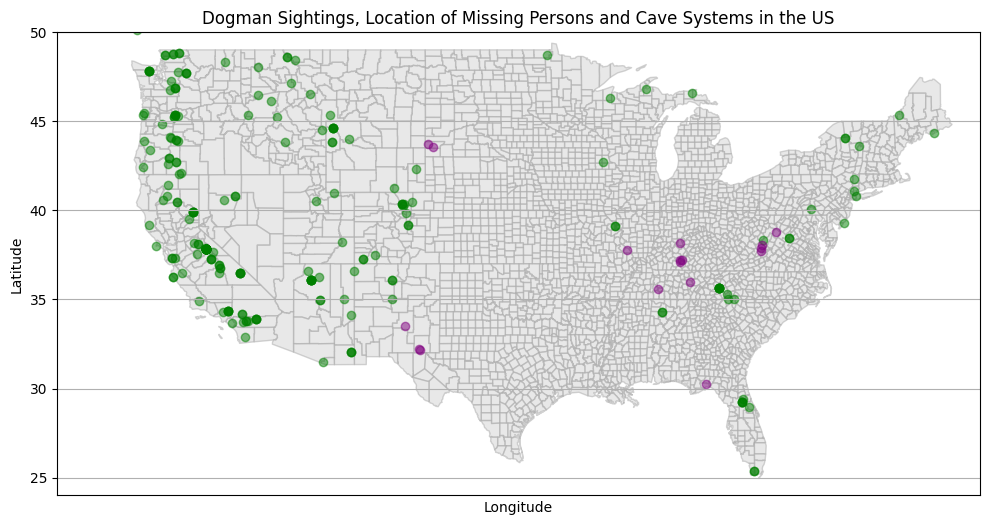

In [477]:
fig, ax = plt.subplots(figsize=(10, 7)) 
usa.plot(ax=ax, color='lightgrey', edgecolor='darkgrey', alpha=0.5)
ax.scatter(victims_coords['longitude'], victims_coords['latitude'], color='green', alpha=0.5)
ax.scatter(updated_us_cave_systems['longitude'], updated_us_cave_systems['latitude'], color='purple', alpha=0.5)
ax.scatter(dogman_sightings['longitude'], dogman_sightings['latitude'], color='blue', alpha=0.5)
ax.set_title('Dogman Sightings, Location of Missing Persons and Cave Systems in the US')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(-130, -65)  # Set x-axis limits for longitude
ax.set_ylim(24, 50)     # Set y-axis limits for latitude
ax.grid(True)          # Add grid lines for better readability
plt.tight_layout()
plt.show()

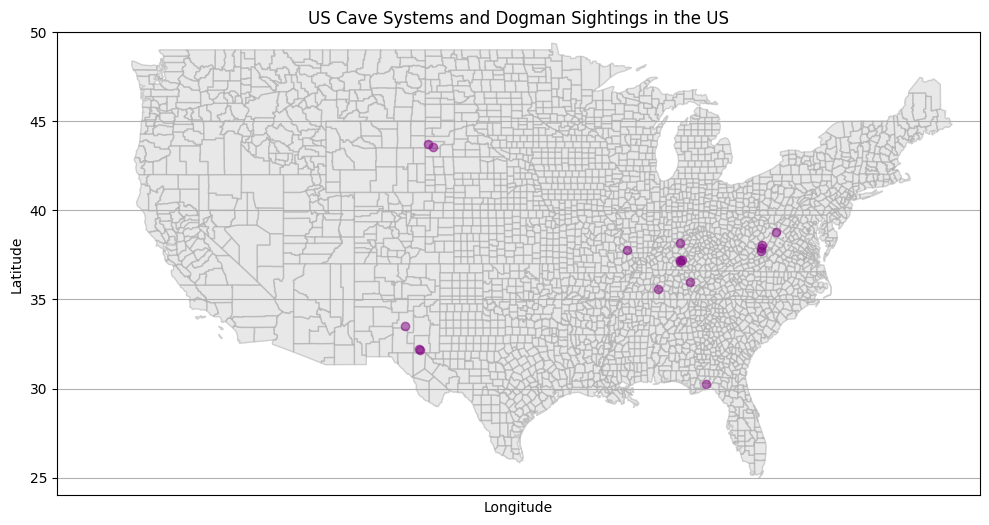

In [478]:
fig, ax = plt.subplots(figsize=(10, 7)) 
usa.plot(ax=ax, color='lightgrey', edgecolor='darkgrey', alpha=0.5)
ax.scatter(dogman_sightings['longitude'], dogman_sightings['latitude'], color='blue', alpha=0.5)
ax.scatter(updated_us_cave_systems['longitude'], updated_us_cave_systems['latitude'], color='purple', alpha=0.5)
ax.set_title('US Cave Systems and Dogman Sightings in the US')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(-130, -65)  # Set x-axis limits for longitude
ax.set_ylim(24, 50)     # Set y-axis limits for latitude
ax.grid(True)          # Add grid lines for better readability
plt.tight_layout()
plt.show()

In [479]:

# Have there been bigfoot sightings near missing persons locations (within 0.1 degree lat/lon)?
query5 = '''
SELECT
    m.park_name,
    COUNT(b.bigfoot_sighting_id) AS bigfoot_sightings_count,
    COUNT(m.missing_persons_id) AS missing_persons_count,
    COUNT(bigfoot_sighting_id) + COUNT(missing_persons_id) AS total_count
FROM
    BigfootSightings b
JOIN
    MissingPersons m ON ABS(b.latitude - m.latitude) <=0.1 AND ABS(b.longitude - m.longitude) <=0.1
WHERE
    ABS(b.latitude - m.latitude) <=0.1 AND ABS(b.longitude - m.longitude) <=0.1
GROUP BY
    m.park_name
ORDER BY
    m.park_name DESC,
    bigfoot_sightings_count DESC,
    missing_persons_count DESC;
'''
result5 = pd.read_sql(query5, conn)
result5

,park_name,bigfoot_sightings_count,missing_persons_count,total_count
0,Yosemite National Park,39,39,78
1,Yellowstone National Park,5,5,10
2,Willamette National Forest,1,1,2
3,West Glacier Park,1,1,2
4,Table Rock State Park,1,1,2
...,...,...,...,...
39,Smoky Mountains National Park,1,1,2
40,Rocky Mounta National Park,1,1,2
41,Mt. Hood National Forest,2,2,4
42,Angeles National Forrest,1,1,2


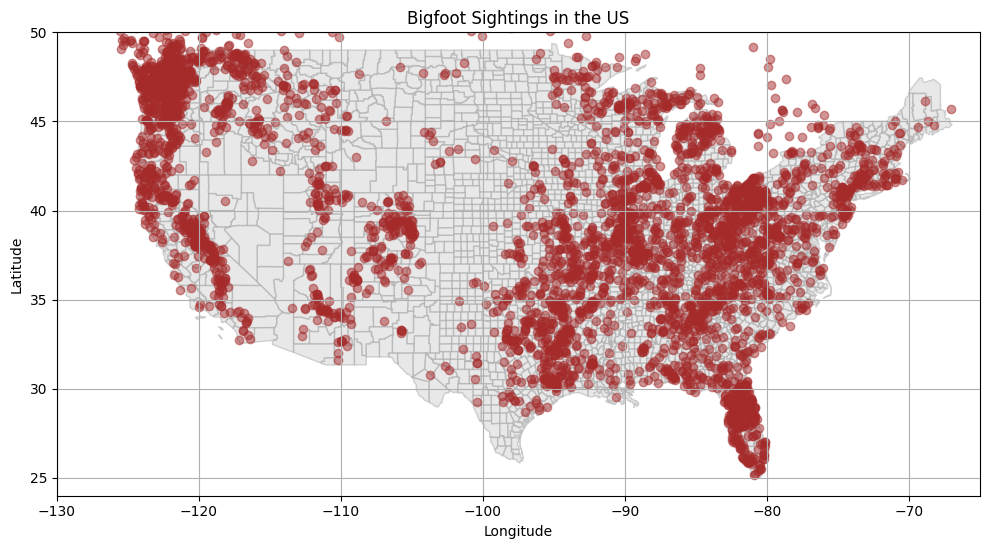

In [480]:
# create a choroplath showing the number of bigfoot sightings per state using geopandas and latitude and longitude columns   
fig, ax = plt.subplots(figsize=(10, 7)) 
usa.plot(ax=ax, color='lightgrey', edgecolor='darkgrey', alpha=0.5)
ax.scatter(bfro_locations['longitude'], bfro_locations['latitude'], color='brown', alpha=0.5)
ax.set_title('Bigfoot Sightings in the US')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(-130, -65)  # Set x-axis limits for longitude
ax.set_ylim(24, 50)     # Set y-axis limits for latitude
ax.grid(True)          # Add grid lines for better readability
plt.tight_layout()
plt.show()

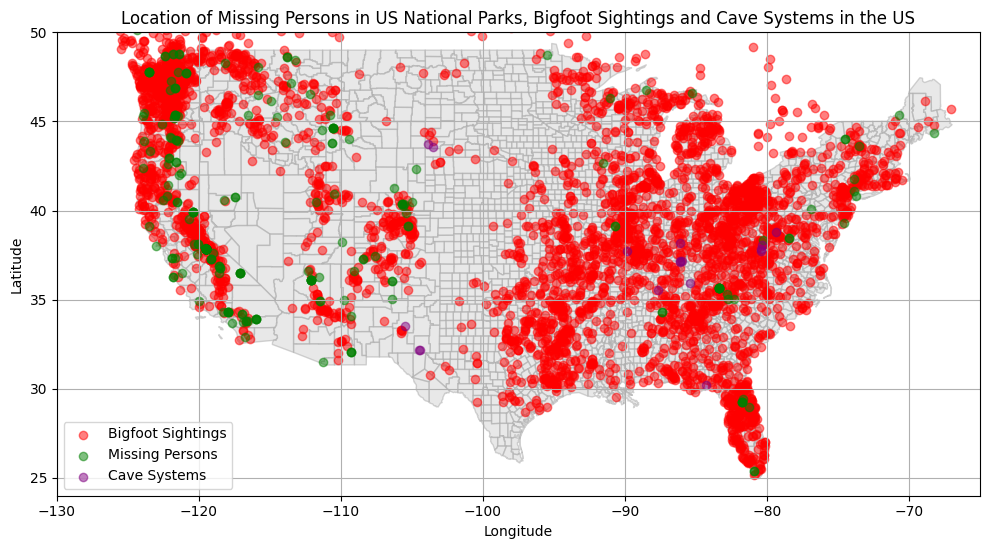

In [481]:
# create heatmap of US bigfoot sightings compared to ufo sightings
fig, ax = plt.subplots(figsize=(10, 7)) 
usa.plot(ax=ax, color='lightgrey', edgecolor='darkgrey', alpha=0.5)
ax.scatter(bfro_locations['longitude'], bfro_locations['latitude'], color='red', alpha=0.5, label='Bigfoot Sightings')
ax.scatter(victims_coords['longitude'], victims_coords['latitude'], color='green', alpha=0.5, label='Missing Persons')
ax.scatter(updated_us_cave_systems['longitude'], updated_us_cave_systems['latitude'], color='purple', alpha=0.5, label='Cave Systems')
ax.set_title('Location of Missing Persons in US National Parks, Bigfoot Sightings and Cave Systems in the US')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(-130, -65)  # Set x-axis limits for longitude
ax.set_ylim(24, 50)     # Set y-axis limits for latitude
ax.grid(True)          # Add grid lines for better readability
ax.legend()
plt.tight_layout()
plt.show()
